In [ ]:
import numpy as np
import os
import umap
import umap.plot
import matplotlib.pyplot as plt

/home/lamsade/msammut/error_detection/error-estimation/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lamsade/msammut/error_detection/error-estimation/myenv/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/lamsade/msammut/error_detection/error-estimation/myenv/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature

# Cifar10

## Gini

Max proba for correctly classified: 0.9870145 ± 0.06503228
Max proba for misclassified: 0.77961856 ± 0.22499867


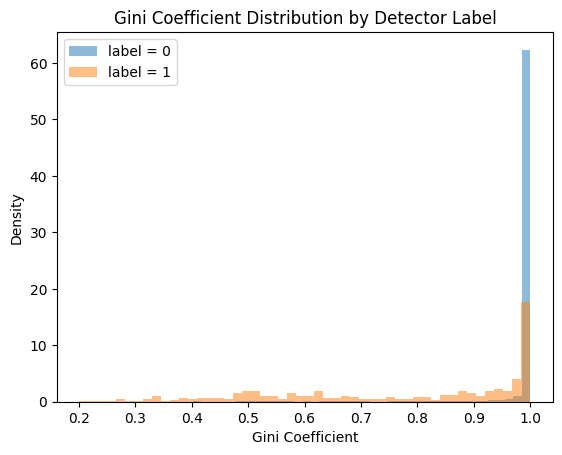

In [10]:
gini_0 = np.sum(train_embs[train_detector_labels == 0] ** 2, axis=1)
gini_1 = np.sum(train_embs[train_detector_labels == 1] ** 2, axis=1)

print("Max proba for correctly classified:", np.mean(gini_0), "±", np.std(gini_0))
print("Max proba for misclassified:", np.mean(gini_1), "±", np.std(gini_1))

# Plot distributions
plt.figure()
plt.hist(gini_0, bins=50, density=True, alpha=0.5, label="label = 0")
plt.hist(gini_1, bins=50, density=True, alpha=0.5, label="label = 1")
plt.xlabel("Gini Coefficient")
plt.ylabel("Density")
plt.title("Gini Coefficient Distribution by Detector Label")
plt.legend()
plt.show()

## Clustering Probits

### Functions

In [2]:

def plot_probits_boxplots_log(
    train_embs: np.ndarray,
    train_labels: np.ndarray,
    train_detector_labels: np.ndarray,
    class_idx: int,
    correct_label: int = 0,
    wrong_label:   int = 1,
    box_width: float = 0.35,
):
    """
    Same as plot_probits_boxplots, but with a logarithmic y-axis.
    """
    # filter to the class of interest
    mask = (train_labels == class_idx)
    embs_cls = train_embs[mask]
    det = train_detector_labels[mask]

    embs_corr = embs_cls[det == correct_label]
    embs_wrng = embs_cls[det == wrong_label]

    if embs_corr.size == 0 or embs_wrng.size == 0:
        raise ValueError("Need at least one sample in each group for boxplots.")

    n_classes = embs_cls.shape[1]
    classes = np.arange(n_classes)

    # prepare data lists for boxplot
    data_corr = [embs_corr[:, j] for j in classes]
    data_wrng = [embs_wrng[:, j] for j in classes]

    pos_corr = classes - box_width/2
    pos_wrng = classes + box_width/2

    fig, ax = plt.subplots(figsize=(8, 5))
    b_corr = ax.boxplot(
        data_corr, positions=pos_corr, widths=box_width,
        patch_artist=True, showfliers=False
    )
    b_wrng = ax.boxplot(
        data_wrng, positions=pos_wrng, widths=box_width,
        patch_artist=True, showfliers=False
    )

    for box in b_corr['boxes']:
        box.set(facecolor='C0', alpha=0.6)
    for box in b_wrng['boxes']:
        box.set(facecolor='C1', alpha=0.6)

    ax.set_xticks(classes)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_xlabel("Predicted Class Index", fontsize=12)
    ax.set_ylabel("Softmax Probability (log scale)", fontsize=12)
    ax.set_title(f"Softmax Distributions (log) for True Class {class_idx}", fontsize=14)

    # Set log scale on y-axis
    ax.set_yscale('log')
    # Optional: tighten the bottom so you can see probabilities ≪ 1e-3
    ax.set_ylim(bottom=1e-6)

    ax.grid(True, which='both', linestyle='--', alpha=0.4)

    # Legend via proxy artists
    proxy_corr = plt.Rectangle((0,0),1,1, facecolor='C0', alpha=0.6)
    proxy_wrng = plt.Rectangle((0,0),1,1, facecolor='C1', alpha=0.6)
    ax.legend([proxy_corr, proxy_wrng], ["Correctly Classified", "Wrongly Classified"],
              loc='upper left', bbox_to_anchor=(1.02, 1))

    plt.tight_layout()
    plt.show()



def plot_all_probits_boxplots_log(
    train_embs: np.ndarray,
    train_labels: np.ndarray,
    train_detector_labels: np.ndarray,
    correct_label: int = 0,
    wrong_label:   int = 1,
    box_width: float = 0.35,
    subtitle_fontsize: int = 10,
):
    """
    For each true class in CIFAR-10, draw side-by-side boxplots of the softmax
    embeddings (on a log scale) over predicted classes, 
    comparing correctly vs wrongly detected samples.
    All 10 subplots appear in a single 2×5 figure.
    """
    # CIFAR-10 class names
    class_names = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]
    n_true = len(class_names)
    n_pred  = train_embs.shape[1]

    # Setup figure with 2 rows × 5 cols
    fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey=True)
    axes = axes.ravel()

    for true_idx, ax in enumerate(axes):
        # select all samples whose true label is true_idx
        mask     = (train_labels == true_idx)
        embs_cls = train_embs[mask]
        det      = train_detector_labels[mask]

        embs_corr = embs_cls[det == correct_label]
        embs_wrng = embs_cls[det == wrong_label]

        if embs_corr.size == 0 or embs_wrng.size == 0:
            ax.text(0.5, 0.5, 'no data', ha='center', va='center')
            ax.set_title(class_names[true_idx], fontsize=subtitle_fontsize)
            continue

        classes = np.arange(n_pred)
        data_corr = [embs_corr[:, j] for j in classes]
        data_wrng = [embs_wrng[:, j] for j in classes]

        pos_corr = classes - box_width/2
        pos_wrng = classes + box_width/2

        # boxplots
        b_corr = ax.boxplot(
            data_corr, positions=pos_corr, widths=box_width,
            patch_artist=True, showfliers=False
        )
        b_wrng = ax.boxplot(
            data_wrng, positions=pos_wrng, widths=box_width,
            patch_artist=True, showfliers=False
        )
        for box in b_corr['boxes']:
            box.set(facecolor='C0', alpha=0.6)
        for box in b_wrng['boxes']:
            box.set(facecolor='C1', alpha=0.6)

        ax.set_xticks(classes)
        ax.set_xticklabels(class_names, rotation=45, fontsize=8)
        ax.set_yscale('log')
        ax.set_ylim(bottom=1e-6)
        ax.grid(True, which='both', linestyle='--', alpha=0.4)
        ax.set_title(class_names[true_idx], fontsize=subtitle_fontsize)

        # only label y‐axis on leftmost plots
        if true_idx % 5 == 0:
            ax.set_ylabel("Softmax Prob. (log)", fontsize=10)

    # create a single legend for the whole figure
    proxy_corr = plt.Rectangle((0,0),1,1, facecolor='C0', alpha=0.6)
    proxy_wrng = plt.Rectangle((0,0),1,1, facecolor='C1', alpha=0.6)
    fig.legend(
        [proxy_corr, proxy_wrng],
        ["Correctly Classified", "Wrongly Classified"],
        loc='upper center', ncols=2, frameon=False, fontsize=12
    )

    fig.suptitle("CIFAR-10 Softmax Distributions by True Class (log scale)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def plot_probits_cluster(
    train_embs: np.ndarray,
    train_labels: np.ndarray,
    train_detector_labels: np.ndarray,
    cluster_idx: int,
    correct_label: int = 0,
    wrong_label:   int = 1,
    box_width: float = 0.35,
):
    """
    Same as plot_probits_boxplots, but with a logarithmic y-axis.
    """
    # filter to the class of interest
    mask = (train_labels == cluster_idx)
    embs_cls = train_embs[mask]
    det = train_detector_labels[mask]

    embs_corr = embs_cls[det == correct_label]
    embs_wrng = embs_cls[det == wrong_label]

    if embs_corr.size == 0 or embs_wrng.size == 0:
        raise ValueError("Need at least one sample in each group for boxplots.")

    n_classes = embs_cls.shape[1]
    classes = np.arange(n_classes)

    # prepare data lists for boxplot
    data_corr = [embs_corr[:, j] for j in classes]
    data_wrng = [embs_wrng[:, j] for j in classes]

    pos_corr = classes - box_width/2
    pos_wrng = classes + box_width/2

    fig, ax = plt.subplots(figsize=(8, 5))
    b_corr = ax.boxplot(
        data_corr, positions=pos_corr, widths=box_width,
        patch_artist=True, showfliers=False
    )
    b_wrng = ax.boxplot(
        data_wrng, positions=pos_wrng, widths=box_width,
        patch_artist=True, showfliers=False
    )

    for box in b_corr['boxes']:
        box.set(facecolor='C0', alpha=0.6)
    for box in b_wrng['boxes']:
        box.set(facecolor='C1', alpha=0.6)

    ax.set_xticks(classes)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_xlabel("Predicted Class Index", fontsize=12)
    ax.set_ylabel("Softmax Probability (log scale)", fontsize=12)
    ax.set_title(f"Softmax Distributions (log) for Cluster {cluster_idx}", fontsize=14)

    # Set log scale on y-axis
    ax.set_yscale('log')
    # Optional: tighten the bottom so you can see probabilities ≪ 1e-3
    ax.set_ylim(bottom=1e-6)

    ax.grid(True, which='both', linestyle='--', alpha=0.4)

    # Legend via proxy artists
    proxy_corr = plt.Rectangle((0,0),1,1, facecolor='C0', alpha=0.6)
    proxy_wrng = plt.Rectangle((0,0),1,1, facecolor='C1', alpha=0.6)
    ax.legend([proxy_corr, proxy_wrng], ["Correctly Classified", "Wrongly Classified"],
              loc='upper left', bbox_to_anchor=(1.02, 1))

    plt.tight_layout()
    plt.show()

### Train vs Eval

In [ ]:
RESULTS_DIR = "../../../synth_results/clustering_probits/experiment_5"

data = np.load(os.path.join(RESULTS_DIR, "detector_train_predictions.npz"))
train_embs = data["embs"]
train_detector_preds = data["detector_preds"]
train_detector_labels = data["detector_labels"]
train_clusters = data["clusters"]


/home/lamsade/msammut/error_detection/error-estimation/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


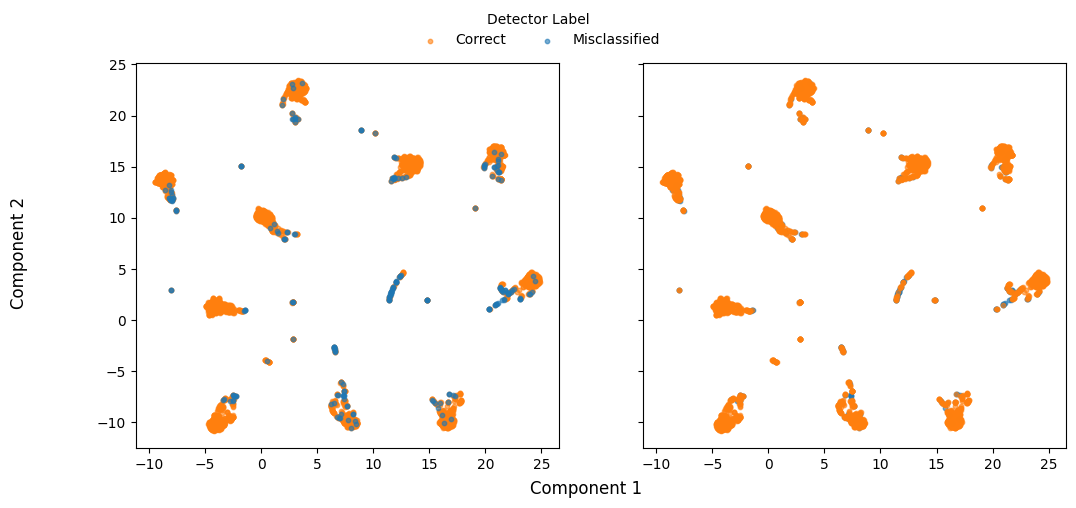

In [ ]:
reducing_dim = 2
n_neighbors = 4
reducer = umap.UMAP(
    metric='cosine',
    # n_components=reducing_dim,
    n_neighbors= n_neighbors
                    ).fit(train_embs)

X = reducer.transform(train_embs)
colour_map = {0: "tab:orange", 1: "tab:blue"}
label_names = {0: "Correct",  1: "Misclassified"}
orders = [
    ([0, 1], "Draw order: 0 → 1"),
    ([1, 0], "Draw order: 1 → 0")
]

# 1×2 grid, shared axes
fig, axes = plt.subplots(
    1, 2,
    figsize=(12, 5),
    sharex=True,
    sharey=True
)

# Plot into each subplot
for ax, (order, title) in zip(axes, orders):
    for label in order:
        mask = (train_detector_labels == label)
        ax.scatter(
            X[mask, 0], X[mask, 1],
            c=colour_map[label],
            s=10,
            alpha=0.6,
            label=label_names[label]
        )
    # ax.set_title()

# Extract one set of handles & labels, then make a single legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title="Detector Label",
    loc="upper center",
    ncol=2,
    frameon=False
)

# Common axis labels
fig.supxlabel("Component 1")
fig.supylabel("Component 2")

# Adjust layout so legend and labels fit
# plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


/home/lamsade/msammut/error_detection/error-estimation/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lamsade/msammut/error_detection/error-estimation/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


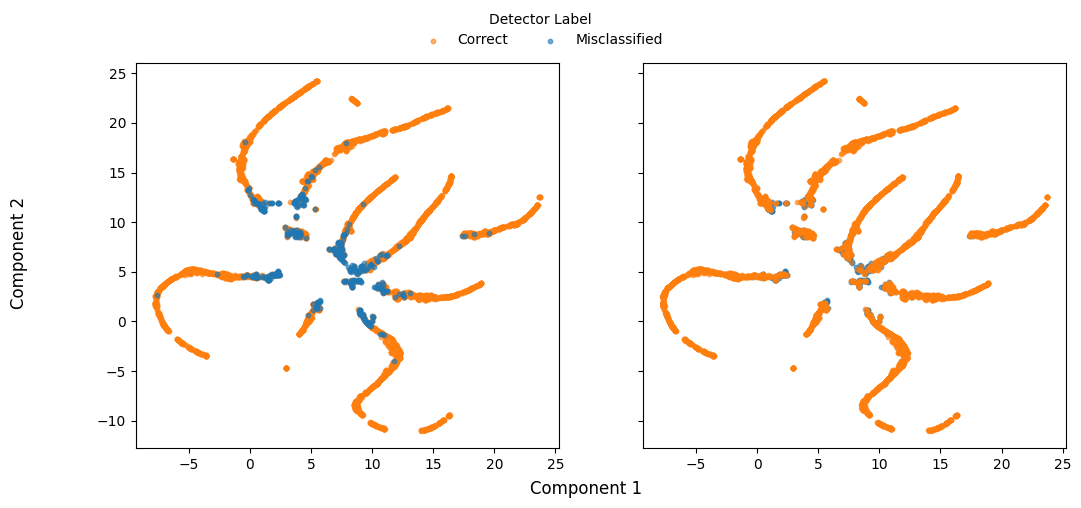

In [19]:
reducing_dim = 2
n_neighbors = 9
reducer = umap.UMAP(
    metric='euclidean',
    # n_components=reducing_dim,
    n_neighbors= n_neighbors
                    ).fit(train_embs)

X = reducer.transform(train_embs)
colour_map = {0: "tab:orange", 1: "tab:blue"}
label_names = {0: "Correct",  1: "Misclassified"}
orders = [
    ([0, 1], "Draw order: 0 → 1"),
    ([1, 0], "Draw order: 1 → 0")
]

# 1×2 grid, shared axes
fig, axes = plt.subplots(
    1, 2,
    figsize=(12, 5),
    sharex=True,
    sharey=True
)

# Plot into each subplot
for ax, (order, title) in zip(axes, orders):
    for label in order:
        mask = (train_detector_labels == label)
        ax.scatter(
            X[mask, 0], X[mask, 1],
            c=colour_map[label],
            s=10,
            alpha=0.6,
            label=label_names[label]
        )
    # ax.set_title()

# Extract one set of handles & labels, then make a single legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title="Detector Label",
    loc="upper center",
    ncol=2,
    frameon=False
)

# Common axis labels
fig.supxlabel("Component 1")
fig.supylabel("Component 2")

# Adjust layout so legend and labels fit
# plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### All data

In [2]:
RESULTS_DIR = "../../../synth_results/all_cifar10/experiment_7"

data = np.load(os.path.join(RESULTS_DIR, "detector_train_predictions.npz"),  allow_pickle=True)
train_embs = data["embs"]
train_detector_preds = data["detector_preds"]
train_detector_labels = data["detector_labels"]
train_clusters = data["clusters"]
train_labels = data["labels"]


#### Max Proba

In [3]:
embs_0 = train_embs[train_detector_labels == 0]
embs_1 = train_embs[train_detector_labels == 1]
print("embs_0 shape:", embs_0.shape)
# Get maximum value
embs_max_0 = np.max(embs_0, axis=1)
embs_max_1 = np.max(embs_1, axis=1)

print("Max proba for correctly classified:", np.mean(embs_max_0), "±", np.std(embs_max_0))
print("Max proba for misclassified:", np.mean(embs_max_1), "±", np.std(embs_max_1))

embs_0 shape: (9532, 10)
Max proba for correctly classified: 0.9913931 ± 0.04869378
Max proba for misclassified: 0.8419684 ± 0.18168756


In [7]:
# import numpy as np

# # Assume:
# #   train_embs           : (N, K) array of original softmax probabilities
# #   train_detector_labels: (N,)   array in {0,1} where 0=correct,1=misclassified

# def temp_scale_probs(probs, T):
#     scaled = probs ** (1.0 / T)
#     return scaled / scaled.sum(axis=1, keepdims=True)

# temps = [0.5, 1.0, 1.5,  2.0, 5.0]   # or any list of temperatures you care about

# for T in temps:
#     embs_T = temp_scale_probs(train_embs, T)

#     # split into correct/misclassified
#     embs0 = embs_T[train_detector_labels == 0]
#     embs1 = embs_T[train_detector_labels == 1]

#     # compute per-sample max confidence
#     max0 = np.max(embs0, axis=1)
#     max1 = np.max(embs1, axis=1)

#     print(f"T = {T}")
#     print("  #samples correct:      ", embs0.shape[0])
#     print("  #samples misclassified:", embs1.shape[0])
#     print("  Max conf (correct):   ",
#           np.mean(max0), "±", np.std(max0))
#     print("  Max conf (misclass):  ",
#           np.mean(max1), "±", np.std(max1))
#     print()


In [4]:
import numpy as np

num_classes = train_embs.shape[1]

for class_idx in range(num_classes):
    # restrict to samples of this true class
    mask      = (train_labels == class_idx)
    embs_cls  = train_embs[mask]
    det_cls   = train_detector_labels[mask]

    # split correct vs. wrong
    embs_corr = embs_cls[det_cls == 0]
    embs_wrng = embs_cls[det_cls == 1]

    # counts
    n_corr = embs_corr.shape[0]
    n_wrng = embs_wrng.shape[0]

    # compute per-sample max softmax
    if n_corr > 0:
        max_corr   = embs_corr.max(axis=1)
        mean_corr  = max_corr.mean()
        std_corr   = max_corr.std()
    else:
        mean_corr = std_corr = np.nan

    if n_wrng > 0:
        max_wrng   = embs_wrng.max(axis=1)
        mean_wrng  = max_wrng.mean()
        std_wrng   = max_wrng.std()
    else:
        mean_wrng = std_wrng = np.nan

    print(
        f"Class {class_idx:2d} | "
        f"Correct (n={n_corr}): {mean_corr:.3f} ± {std_corr:.3f} | "
        f"Wrong   (n={n_wrng}): {mean_wrng:.3f} ± {std_wrng:.3f}"
    )


Class  0 | Correct (n=958): 0.986 ± 0.063 | Wrong   (n=42): 0.857 ± 0.171
Class  1 | Correct (n=978): 0.995 ± 0.037 | Wrong   (n=22): 0.847 ± 0.207
Class  2 | Correct (n=942): 0.991 ± 0.047 | Wrong   (n=58): 0.797 ± 0.184
Class  3 | Correct (n=887): 0.983 ± 0.069 | Wrong   (n=113): 0.876 ± 0.156
Class  4 | Correct (n=966): 0.993 ± 0.041 | Wrong   (n=34): 0.840 ± 0.187
Class  5 | Correct (n=916): 0.988 ± 0.061 | Wrong   (n=84): 0.850 ± 0.174
Class  6 | Correct (n=973): 0.994 ± 0.045 | Wrong   (n=27): 0.823 ± 0.189
Class  7 | Correct (n=970): 0.996 ± 0.030 | Wrong   (n=30): 0.786 ± 0.211
Class  8 | Correct (n=974): 0.993 ± 0.044 | Wrong   (n=26): 0.833 ± 0.178
Class  9 | Correct (n=968): 0.995 ± 0.037 | Wrong   (n=32): 0.839 ± 0.204


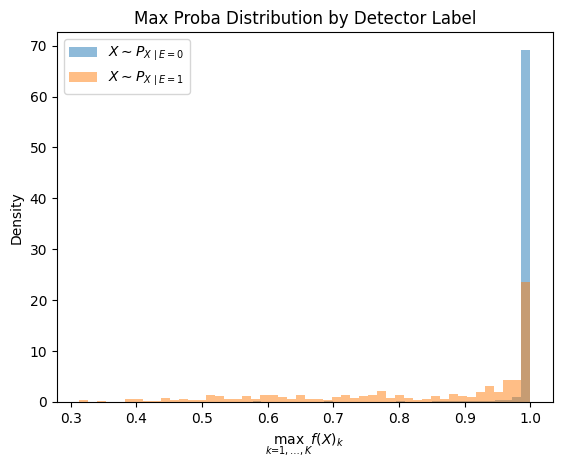

In [6]:
# Plot distributions
plt.figure()
plt.hist(embs_max_0, bins=50, density=True, alpha=0.5, label=r"$X \sim P_{X \mid E=0}$")
plt.hist(embs_max_1, bins=50, density=True, alpha=0.5, label=r"$X \sim P_{X \mid E=1}$")
plt.xlabel(r"$\max_{k =1, \dots, K} f(X)_k$")
plt.ylabel("Density")
plt.title("Max Proba Distribution by Detector Label")
plt.legend()
plt.show()

#### Probits

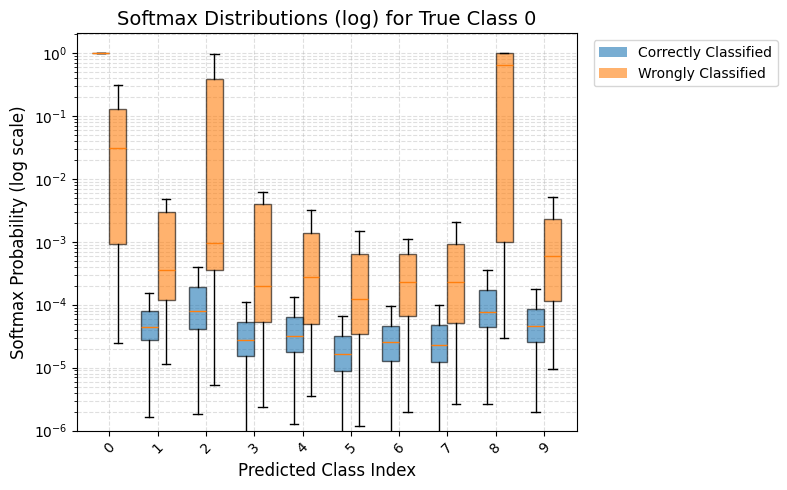

In [ ]:


plot_probits_boxplots_log(
    train_embs,
    train_labels,
    train_detector_labels,
    class_idx=0)


In [ ]:
class_idx =0
mask = (train_labels == class_idx) & (np.argmax(train_embs, axis=1) != class_idx)
# np.unique(np.argmax(train_embs[mask], axis=1), return_counts=True)
predicted_idx = 4
mask_2 = np.argmax(train_embs[mask], axis=1) == predicted_idx


(array([2, 3, 4, 6, 8, 9]), array([11,  4,  1,  1, 23,  2]))

/tmp/ipykernel_3565152/870531703.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', num_samples)


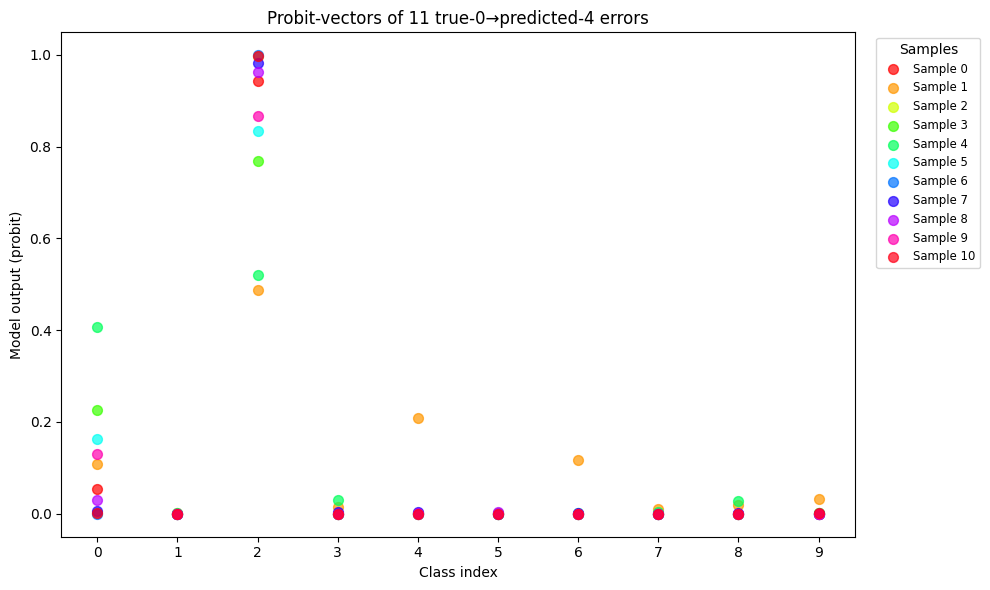

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# --- your data: train_labels (N,), train_embs (N, C) ---
class_idx     = 0
predicted_idx = 2

# mask for true class 0, but mis‐classified
mask     = (train_labels == class_idx) & (np.argmax(train_embs, axis=1) != class_idx)
wrong    = train_embs[mask]                       # shape (M, C)
is_pred4 = np.argmax(wrong, axis=1) == predicted_idx
selected = wrong[is_pred4]                        # shape (K, C)

num_samples = selected.shape[0]
num_classes = train_embs.shape[1]

# pick a colormap with K distinct colors
cmap = plt.cm.get_cmap('hsv', num_samples)

plt.figure(figsize=(10, 6))
for i in range(num_samples):
    # x = class indices [0,1,...,C-1]; y = probit values for sample i
    plt.scatter(
        np.arange(num_classes),
        selected[i],
        color=cmap(i),
        alpha=0.7,
        s=50,
        label=f'Sample {i}'
    )

plt.xticks(np.arange(num_classes))
plt.xlabel('Class index')
plt.ylabel('Model output (probit)')
plt.title(f'Probit‐vectors of {num_samples} true-0→predicted-4 errors')
plt.legend(
    title='Samples',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize='small',
    ncol=1
)
plt.tight_layout()
plt.show()


In [4]:

def plot_probits_boxplots_log(
    train_embs: np.ndarray,
    train_labels: np.ndarray,
    train_detector_labels: np.ndarray,
    class_idx: int,
    correct_label: int = 0,
    wrong_label:   int = 1,
    box_width: float = 0.35,
):
    """
    Same as plot_probits_boxplots, but with a logarithmic y-axis.
    """
    # filter to the class of interest
    mask = (train_labels == class_idx) & (np.argmax(train_embs, axis=1) != class_idx)
    embs_cls = train_embs[mask]
    det = train_detector_labels[mask]

    embs_corr = embs_cls[det == correct_label]
    embs_wrng = embs_cls[det == wrong_label]

    if embs_corr.size == 0 or embs_wrng.size == 0:
        raise ValueError("Need at least one sample in each group for boxplots.")

    n_classes = embs_cls.shape[1]
    classes = np.arange(n_classes)

    # prepare data lists for boxplot
    data_corr = [embs_corr[:, j] for j in classes]
    data_wrng = [embs_wrng[:, j] for j in classes]

    pos_corr = classes - box_width/2
    pos_wrng = classes + box_width/2

    fig, ax = plt.subplots(figsize=(8, 5))
    b_corr = ax.boxplot(
        data_corr, positions=pos_corr, widths=box_width,
        patch_artist=True, showfliers=False
    )
    b_wrng = ax.boxplot(
        data_wrng, positions=pos_wrng, widths=box_width,
        patch_artist=True, showfliers=False
    )

    for box in b_corr['boxes']:
        box.set(facecolor='C0', alpha=0.6)
    for box in b_wrng['boxes']:
        box.set(facecolor='C1', alpha=0.6)

    ax.set_xticks(classes)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_xlabel("Predicted Class Index", fontsize=12)
    ax.set_ylabel("Softmax Probability (log scale)", fontsize=12)
    ax.set_title(f"Softmax Distributions (log) for True Class {class_idx}", fontsize=14)

    # Set log scale on y-axis
    ax.set_yscale('log')
    # Optional: tighten the bottom so you can see probabilities ≪ 1e-3
    ax.set_ylim(bottom=1e-6)

    ax.grid(True, which='both', linestyle='--', alpha=0.4)

    # Legend via proxy artists
    proxy_corr = plt.Rectangle((0,0),1,1, facecolor='C0', alpha=0.6)
    proxy_wrng = plt.Rectangle((0,0),1,1, facecolor='C1', alpha=0.6)
    ax.legend([proxy_corr, proxy_wrng], ["Correctly Classified", "Wrongly Classified"],
              loc='upper left', bbox_to_anchor=(1.02, 1))

    plt.tight_layout()
    plt.show()


plot_probits_boxplots_log(
    train_embs,
    train_labels,
    train_detector_labels,
    class_idx=0)


ValueError: Need at least one sample in each group for boxplots.

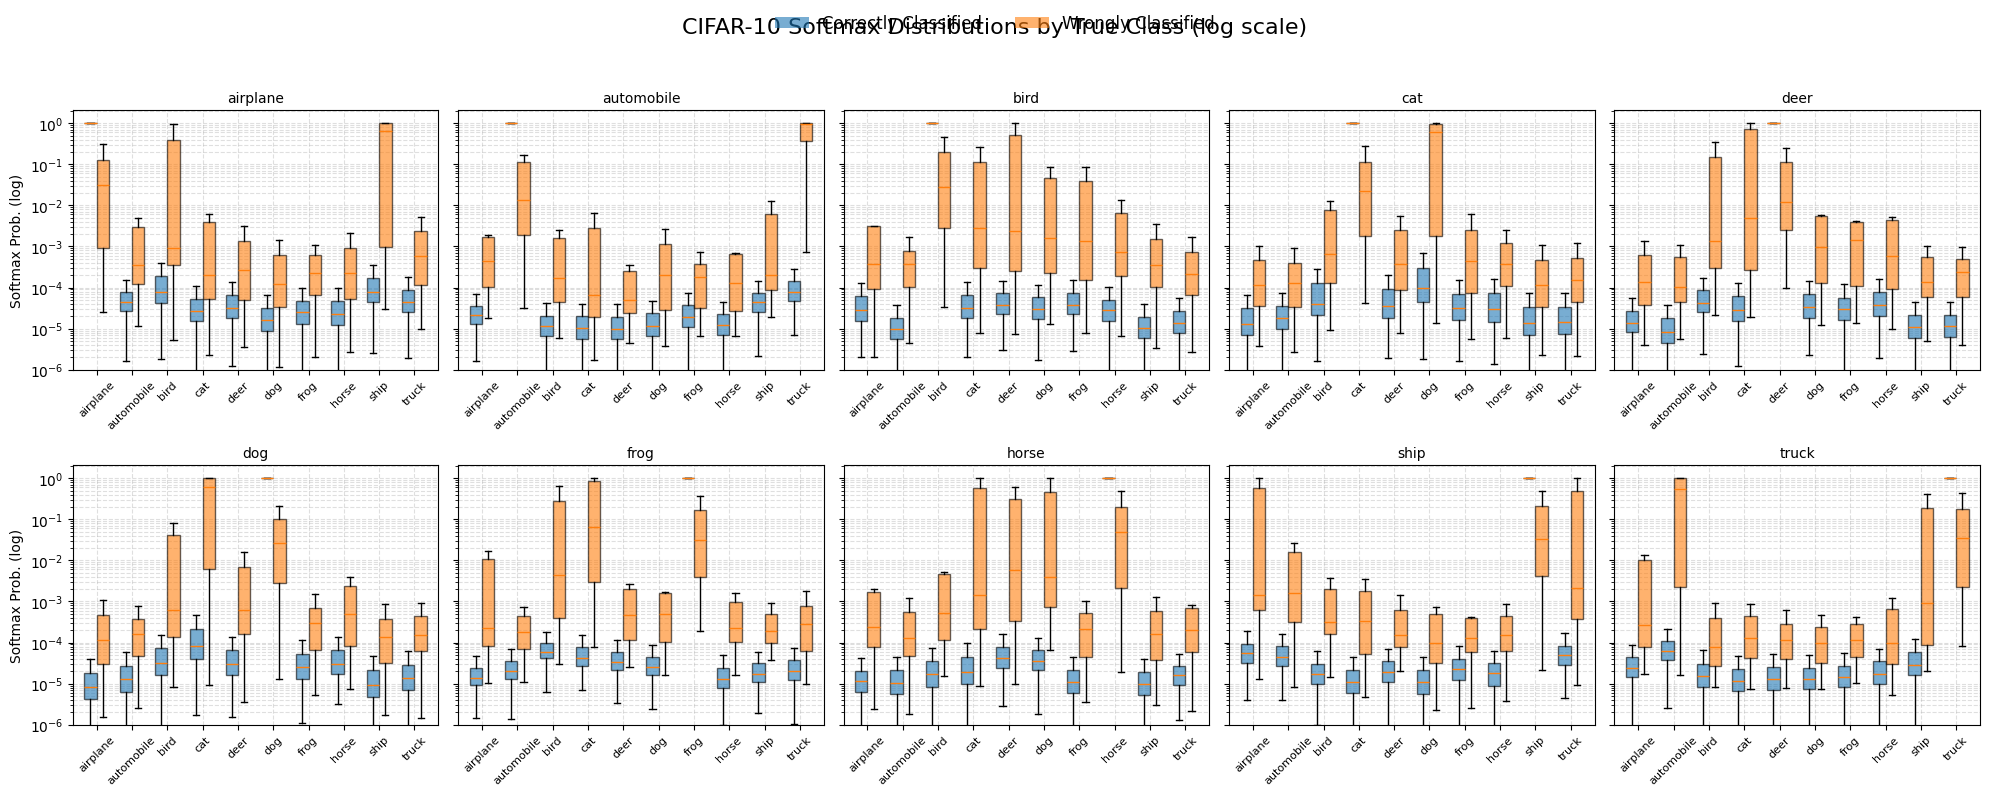

In [ ]:


# Example usage:
plot_all_probits_boxplots_log(
    train_embs,
    train_labels,
    train_detector_labels
)

In [15]:

data = np.load(os.path.join(RESULTS_DIR, "cluster_centers.npz"),  allow_pickle=True)
cluster_centers = data["centers"]

cluster_data = np.load(os.path.join(RESULTS_DIR, "cluster_results.npz"),  allow_pickle=True)
cluster_counts = cluster_data["cluster_counts"]
cluster_error_means = cluster_data["cluster_error_means"]
cluster_error_vars = cluster_data["cluster_error_vars"]
cluster_intervals = cluster_data["cluster_intervals"]

In [28]:
import pandas as pd
pd.DataFrame({
    "cluster_idx": np.arange(len(cluster_counts)),
    "count": cluster_counts,
    "error_mean": cluster_error_means,
    "error_var": cluster_error_vars,
    # "error_interval": cluster_intervals
    })

cluster_idx  count  error_mean  error_var
0             0    981    0.013252   0.013076
1             1    981    0.022426   0.021923
2             2    986    0.032454   0.031401
3             3    974    0.072895   0.067582
4             4    991    0.030272   0.029356
5             5    984    0.021341   0.020886
6             6    991    0.019173   0.018805
7             7    950    0.030526   0.029594
8             8    921    0.068404   0.063725
9             9    954    0.019916   0.019519
10           10     24    0.500000   0.250000
11           11     24    0.500000   0.250000
12           12     33    0.606061   0.238751
13           13     15    0.400000   0.240000
14           14     39    0.410256   0.241946
15           15     41    0.512195   0.249851
16           16     14    0.428571   0.244898
17           17     49    0.571429   0.244898
18           18     11    0.545455   0.247934
19           19     37    0.594595   0.241052

In [34]:
mask = train_clusters == cluster_idx
np.unique(train_labels[mask], return_counts=True)

(array([0, 2, 4, 8, 9]), array([ 5,  1,  1, 13,  4]))

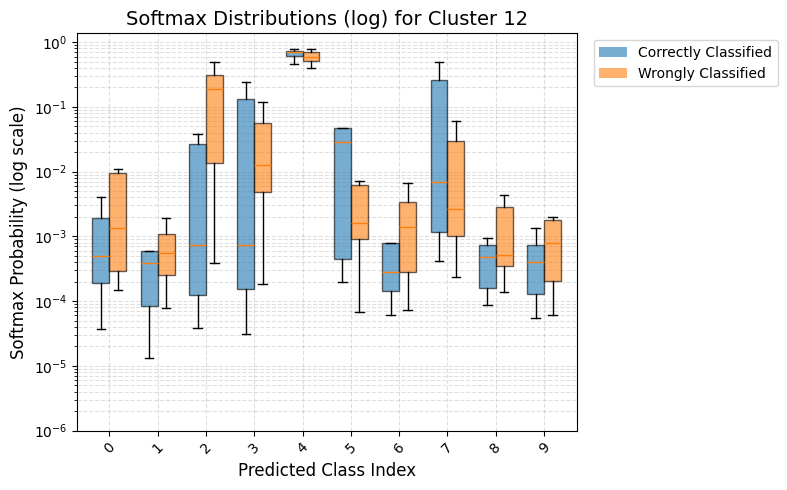

In [35]:
cluster_idx = 12
plot_probits_cluster(
    train_embs,
    train_clusters,
    train_detector_labels,
    cluster_idx=cluster_idx)

In [10]:
# RESULTS_DIR = "../../../synth_results/all_cifar10/experiment_6"

# data = np.load(os.path.join(RESULTS_DIR, "detector_train_predictions.npz"),  allow_pickle=True)
# train_embs = data["embs"]
# train_detector_preds = data["detector_preds"]
# train_detector_labels = data["detector_labels"]
# train_clusters = data["clusters"]
# train_labels = data["labels"]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt





In [8]:
import numpy as np

num_clusters = train_clusters.max() +1

for cluster_idx in range(num_clusters):
    # restrict to samples of this true class
    mask      = (train_clusters == cluster_idx)
    embs_cls  = train_embs[mask]
    det_cls   = train_detector_labels[mask]

    # split correct vs. wrong
    embs_corr = embs_cls[det_cls == 0]
    embs_wrng = embs_cls[det_cls == 1]

    # counts
    n_corr = embs_corr.shape[0]
    n_wrng = embs_wrng.shape[0]

    # compute per-sample max softmax
    if n_corr > 0:
        max_corr   = embs_corr.max(axis=1)
        mean_corr  = max_corr.mean()
        std_corr   = max_corr.std()
    else:
        mean_corr = std_corr = np.nan

    if n_wrng > 0:
        max_wrng   = embs_wrng.max(axis=1)
        mean_wrng  = max_wrng.mean()
        std_wrng   = max_wrng.std()
    else:
        mean_wrng = std_wrng = np.nan

    print(
        f"Class {cluster_idx:2d} | "
        f"Correct (n={n_corr}): {mean_corr:.3f} ± {std_corr:.3f} | "
        f"Wrong   (n={n_wrng}): {mean_wrng:.3f} ± {std_wrng:.3f}"
    )


Class  0 | Correct (n=968): 0.997 ± 0.025 | Wrong   (n=13): 0.936 ± 0.091
Class  1 | Correct (n=959): 0.998 ± 0.012 | Wrong   (n=22): 0.968 ± 0.046
Class  2 | Correct (n=954): 0.997 ± 0.015 | Wrong   (n=32): 0.957 ± 0.055
Class  3 | Correct (n=903): 0.994 ± 0.029 | Wrong   (n=71): 0.929 ± 0.091
Class  4 | Correct (n=961): 0.998 ± 0.013 | Wrong   (n=30): 0.958 ± 0.053
Class  5 | Correct (n=963): 0.998 ± 0.013 | Wrong   (n=21): 0.925 ± 0.079
Class  6 | Correct (n=972): 0.997 ± 0.017 | Wrong   (n=19): 0.932 ± 0.087
Class  7 | Correct (n=921): 0.997 ± 0.012 | Wrong   (n=29): 0.964 ± 0.036
Class  8 | Correct (n=858): 0.995 ± 0.019 | Wrong   (n=63): 0.971 ± 0.040
Class  9 | Correct (n=935): 0.995 ± 0.020 | Wrong   (n=19): 0.962 ± 0.055
Class 10 | Correct (n=12): 0.573 ± 0.102 | Wrong   (n=12): 0.614 ± 0.108
Class 11 | Correct (n=12): 0.666 ± 0.116 | Wrong   (n=12): 0.616 ± 0.105
Class 12 | Correct (n=13): 0.654 ± 0.110 | Wrong   (n=20): 0.605 ± 0.119
Class 13 | Correct (n=9): 0.621 ± 0.147 |

### New Probits visualization

In [4]:
RESULTS_DIR = "../../../synth_results/all_cifar10/experiment_9"

data = np.load(os.path.join(RESULTS_DIR, "detector_train_predictions.npz"),  allow_pickle=True)
train_embs = data["embs"]
train_detector_preds = data["detector_preds"]
train_detector_labels = data["detector_labels"]
train_clusters = data["clusters"]
train_labels = data["labels"]


In [16]:
for class_idx in np.unique(train_labels):
    print("Class", class_idx)
    mask = train_labels == class_idx
    preds, counts = np.unique(np.argmax(train_embs[mask], axis=1), return_counts=True)
    for pred, count in zip(preds, counts):
        print(f"  Predicted {pred}: {count} samples")

Class 0
  Predicted 0: 958 samples
  Predicted 2: 11 samples
  Predicted 3: 4 samples
  Predicted 4: 1 samples
  Predicted 6: 1 samples
  Predicted 8: 23 samples
  Predicted 9: 2 samples
Class 1
  Predicted 0: 3 samples
  Predicted 1: 978 samples
  Predicted 3: 1 samples
  Predicted 4: 1 samples
  Predicted 8: 2 samples
  Predicted 9: 15 samples
Class 2
  Predicted 0: 7 samples
  Predicted 2: 942 samples
  Predicted 3: 10 samples
  Predicted 4: 17 samples
  Predicted 5: 10 samples
  Predicted 6: 10 samples
  Predicted 7: 2 samples
  Predicted 8: 2 samples
Class 3
  Predicted 0: 2 samples
  Predicted 1: 1 samples
  Predicted 2: 11 samples
  Predicted 3: 887 samples
  Predicted 4: 14 samples
  Predicted 5: 63 samples
  Predicted 6: 12 samples
  Predicted 7: 3 samples
  Predicted 8: 5 samples
  Predicted 9: 2 samples
Class 4
  Predicted 0: 1 samples
  Predicted 2: 7 samples
  Predicted 3: 11 samples
  Predicted 4: 966 samples
  Predicted 5: 5 samples
  Predicted 6: 5 samples
  Predicted 7

In [23]:
predicted_idx = 3
mask     = (train_labels == class_idx) & (np.argmax(train_embs, axis=1) == predicted_idx)
train_embs[mask, predicted_idx].mean()

0.6126871

/tmp/ipykernel_3937617/882717093.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', num_samples)


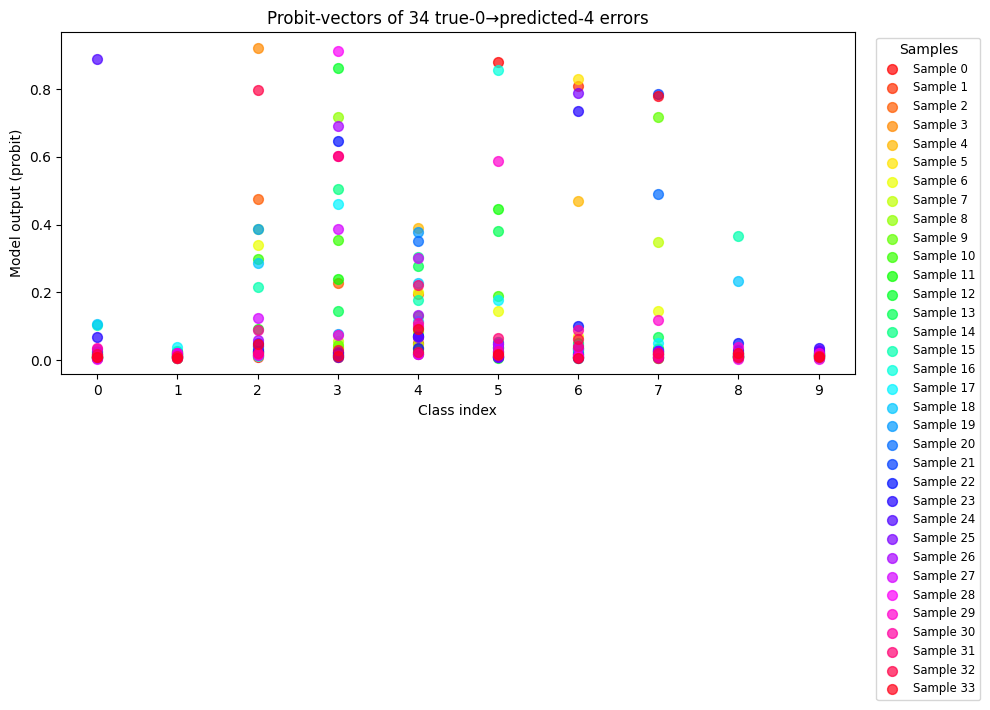

In [ ]:

# --- your data: train_labels (N,), train_embs (N, C) ---
class_idx     = 4
predicted_idx = []

# mask for true class 0, but mis‐classified
mask     = (train_labels == class_idx) & (np.argmax(train_embs, axis=1) != class_idx)
wrong    = train_embs[mask]                       # shape (M, C)

if predicted_idx is not None:
    is_pred = np.argmax(wrong, axis=1) == predicted_idx
    selected = wrong[is_pred]                    # shape (K, C)
else:
    selected = wrong                       # shape (K, C)

num_samples = selected.shape[0]
num_classes = train_embs.shape[1]

# pick a colormap with K distinct colors
cmap = plt.cm.get_cmap('hsv', num_samples)

plt.figure(figsize=(10, 6))
for i in range(num_samples):
    # x = class indices [0,1,...,C-1]; y = probit values for sample i
    plt.scatter(
        np.arange(num_classes),
        selected[i],
        color=cmap(i),
        alpha=0.7,
        s=50,
        label=f'Sample {i}'
    )

plt.xticks(np.arange(num_classes))
plt.xlabel('Class index')
plt.ylabel('Model output (probit)')
plt.title(f'Probit‐vectors of {num_samples} true-0→predicted-4 errors')
plt.legend(
    title='Samples',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize='small',
    ncol=1
)
plt.tight_layout()
plt.show()

In [8]:
mask = train_clusters == cluster_idx
# np.unique(train_detector_labels[mask], return_counts=True)
for cluster_idx in range(train_clusters.max() + 1):
    mask = train_clusters == cluster_idx
    print(f"Cluster {cluster_idx}:")
    # print(np.unique(train_detector_labels[mask], return_counts=True))
    # print(np.unique(train_labels[mask], return_counts=True))
    print("Predicted class counts:", np.unique(np.argmax(train_embs[mask], axis=1), return_counts=True))
    print()


Cluster 0:
Predicted class counts: (array([9]), array([728]))

Cluster 1:
Predicted class counts: (array([0]), array([771]))

Cluster 2:
Predicted class counts: (array([4]), array([847]))

Cluster 3:
Predicted class counts: (array([8]), array([139]))

Cluster 4:
Predicted class counts: (array([3]), array([227]))

Cluster 5:
Predicted class counts: (array([2]), array([214]))

Cluster 6:
Predicted class counts: (array([1]), array([869]))

Cluster 7:
Predicted class counts: (array([7]), array([869]))

Cluster 8:
Predicted class counts: (array([5]), array([673]))

Cluster 9:
Predicted class counts: (array([6]), array([839]))

Cluster 10:
Predicted class counts: (array([3]), array([625]))

Cluster 11:
Predicted class counts: (array([2]), array([662]))

Cluster 12:
Predicted class counts: (array([9]), array([191]))

Cluster 13:
Predicted class counts: (array([1, 8, 9]), array([122,  14,  47]))

Cluster 14:
Predicted class counts: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([57, 12,  3, 57,

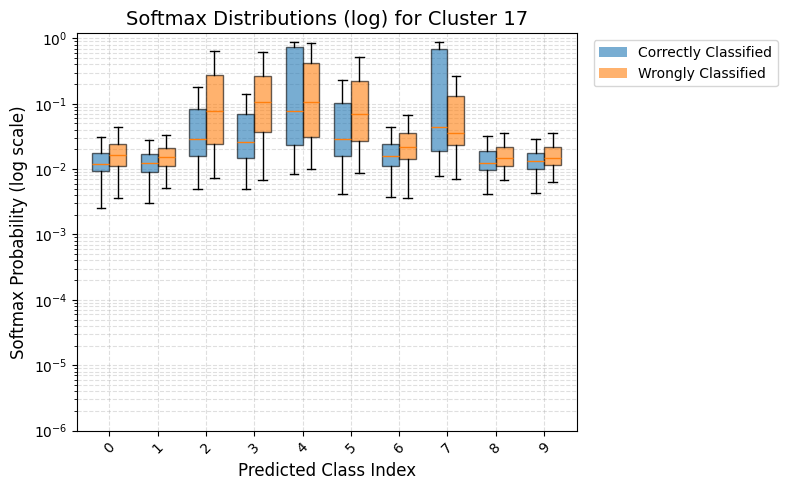

In [9]:
cluster_idx = 17
plot_probits_cluster(
    train_embs,
    train_clusters,
    train_detector_labels,
    cluster_idx=cluster_idx)

### Restricted classes

In [5]:
RESULTS_DIR = "../../../synth_results/restricted_cifar10/experiment_1"

data = np.load(os.path.join(RESULTS_DIR, "detector_train_predictions.npz"),  allow_pickle=True)
n_train_embs = data["embs"]
n_train_detector_preds = data["detector_preds"]
n_train_detector_labels = data["detector_labels"]
n_train_clusters = data["clusters"]
n_train_labels = data["labels"]


In [9]:
n_train_labels

array([3, 3, 5, ..., 0, 0, 3])

In [18]:
desired_classes

array([0, 3, 5])

In [ ]:
desired_classes = np.unique(n_train_labels)
mask = np.isin(train_labels, desired_classes)
train_embs[mask, [0,3,5]dfdaadddaaaaazaassssaaaall  ffffsssssssssssss]

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (3000,) (3,) 

### Verification

In [2]:
RESULTS_DIR = "../../../synth_results/all_cifar10/experiment_7"

data = np.load(os.path.join(RESULTS_DIR, "detector_train_predictions.npz"),  allow_pickle=True)
train_embs = data["embs"]
train_detector_preds = data["detector_preds"]
train_detector_labels = data["detector_labels"]
train_clusters = data["clusters"]
train_labels = data["labels"]


In [3]:
cluster_data = np.load(os.path.join(RESULTS_DIR, "cluster_results.npz"),  allow_pickle=True)
cluster_counts = cluster_data["cluster_counts"]
cluster_error_means = cluster_data["cluster_error_means"]
cluster_error_vars = cluster_data["cluster_error_vars"]
cluster_intervals = cluster_data["cluster_intervals"]



In [18]:
## Counts
unique, counts = np.unique(train_clusters, return_counts=True)

if np.alltrue(counts == cluster_counts):
    print("Cluster counts match expected values.")
else:
    print("Cluster counts do not match expected values.")
    print("Expected:", cluster_counts)
    print("Actual:  ", counts)


Cluster counts match expected values.


In [17]:
# ## ALL good
# n_cluster = train_clusters.max() + 1
# for cluster_idx in range(n_cluster):
#     print(
#         f"Cluster {cluster_idx:2d} | "
#         f"Error Mean: {cluster_error_means[cluster_idx]:.3f} | "
#         f"Error Var:  {cluster_error_vars[cluster_idx]:.3f} | "
#         f"Interval:   {cluster_intervals[cluster_idx]}"
#     )
#     # Compute values
#     cluster_mask = (train_clusters == cluster_idx)

#     mean = train_detector_labels[cluster_mask].mean()
#     var = train_detector_labels[cluster_mask].var()
#     print(f"Cluster {cluster_idx:2d} | "
#           f"Mean: {mean:.3f} | "
#           f"Var:  {var:.3f}")


In [33]:
np.unique(train_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

In [31]:
for cluster_idx in range(n_cluster):
    mask = (train_clusters == cluster_idx)
    num_çlass, counts = np.unique(train_labels[mask], return_counts=True)
    print(f"Cluster {cluster_idx:2d} | "
          f"Class Counts: {dict(zip(num_çlass, counts))} | "
          f"Total: {mask.sum()} | "
    )

Cluster  0 | Class Counts: {2: 2, 3: 2, 4: 4, 5: 4, 6: 1, 7: 968} | Total: 981 | 
Cluster  1 | Class Counts: {0: 1, 1: 13, 3: 2, 5: 1, 8: 5, 9: 959} | Total: 981 | 
Cluster  2 | Class Counts: {2: 6, 3: 12, 4: 954, 5: 7, 6: 1, 7: 5, 8: 1} | Total: 986 | 
Cluster  3 | Class Counts: {2: 8, 3: 52, 4: 4, 5: 903, 7: 6, 8: 1} | Total: 974 | 
Cluster  4 | Class Counts: {0: 18, 1: 2, 2: 1, 3: 5, 8: 961, 9: 4} | Total: 991 | 
Cluster  5 | Class Counts: {0: 1, 2: 6, 3: 9, 4: 4, 5: 1, 6: 963} | Total: 984 | 
Cluster  6 | Class Counts: {1: 972, 3: 1, 5: 1, 8: 3, 9: 14} | Total: 991 | 
Cluster  7 | Class Counts: {0: 7, 2: 921, 3: 8, 4: 2, 5: 7, 6: 3, 8: 2} | Total: 950 | 
Cluster  8 | Class Counts: {0: 2, 1: 1, 2: 4, 3: 858, 4: 8, 5: 35, 6: 7, 7: 4, 8: 1, 9: 1} | Total: 921 | 
Cluster  9 | Class Counts: {0: 935, 2: 3, 4: 1, 5: 1, 6: 4, 7: 2, 8: 5, 9: 3} | Total: 954 | 
Cluster 10 | Class Counts: {2: 5, 3: 4, 4: 1, 5: 3, 6: 11} | Total: 24 | 
Cluster 11 | Class Counts: {0: 5, 2: 1, 4: 1, 8: 13, 9: 4}

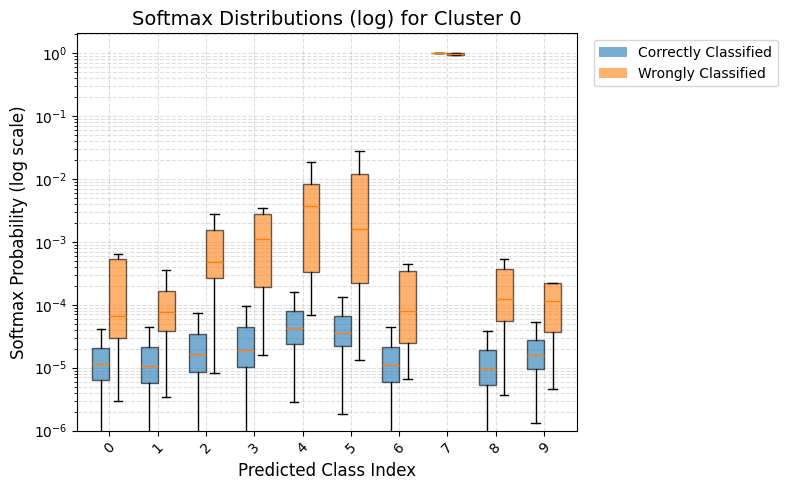

In [35]:

plot_probits_cluster(
    train_embs,
    train_clusters,
    train_detector_labels,
    cluster_idx=0)

## Input spaces

In [3]:
# 1. Your current working directory (where relative imports/files will be resolved)
print("CWD:", os.getcwd())

CWD: /home/lamsade/msammut/error_detection/error-estimation/synthetic_code/utils/clustering


In [8]:
import sys
# so two levels up is project/
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils.datasets import GaussianMixtureDataset, get_dataset, get_synthetic_dataset

In [36]:
from torch.utils.data import DataLoader
import torch
from transformers import CLIPModel, CLIPProcessor, CLIPImageProcessor
from sklearn.manifold import TSNE
from torchvision import transforms
from torchvision.datasets import CIFAR10


In [ ]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from transformers import CLIPModel, CLIPImageProcessor
import torch
from sklearn.manifold import TSNE

DATA_DIR = "../../../data"

# 1) Define a collate_fn that keeps PILs as a Python list
def collate_pil(batch):
    images, labels = zip(*batch)
    return list(images), torch.tensor(labels, dtype=torch.long)

# 2) Raw‐PIL dataset
dataset = CIFAR10(
    root=DATA_DIR,
    train=False,
    download=False,
    transform=None      # yields PIL.Images
)

loader = DataLoader(
    dataset,
    batch_size=256,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_pil
)

# 3) CLIP
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 4) Extract embeddings
all_embeds, all_labels = [], []
model.eval()

with torch.no_grad():
    for pil_images, labels in loader:
        # processor handles Resize → ToTensor → Normalize
        inputs       = processor(images=pil_images, return_tensors="pt")
        pixel_values = inputs.pixel_values.to(device)   # (B,3,224,224)
        feats        = model.get_image_features(pixel_values=pixel_values)
        all_embeds.append(feats.cpu().numpy())
        all_labels.append(labels.numpy())
        print(labels[:15])
        

embeds = np.concatenate(all_embeds, axis=0)  # (N,512)
labels = np.concatenate(all_labels, axis=0)  # (N,)


Reducing to 2D with t-SNE...
t-SNE done. Shape: (10000, 2)


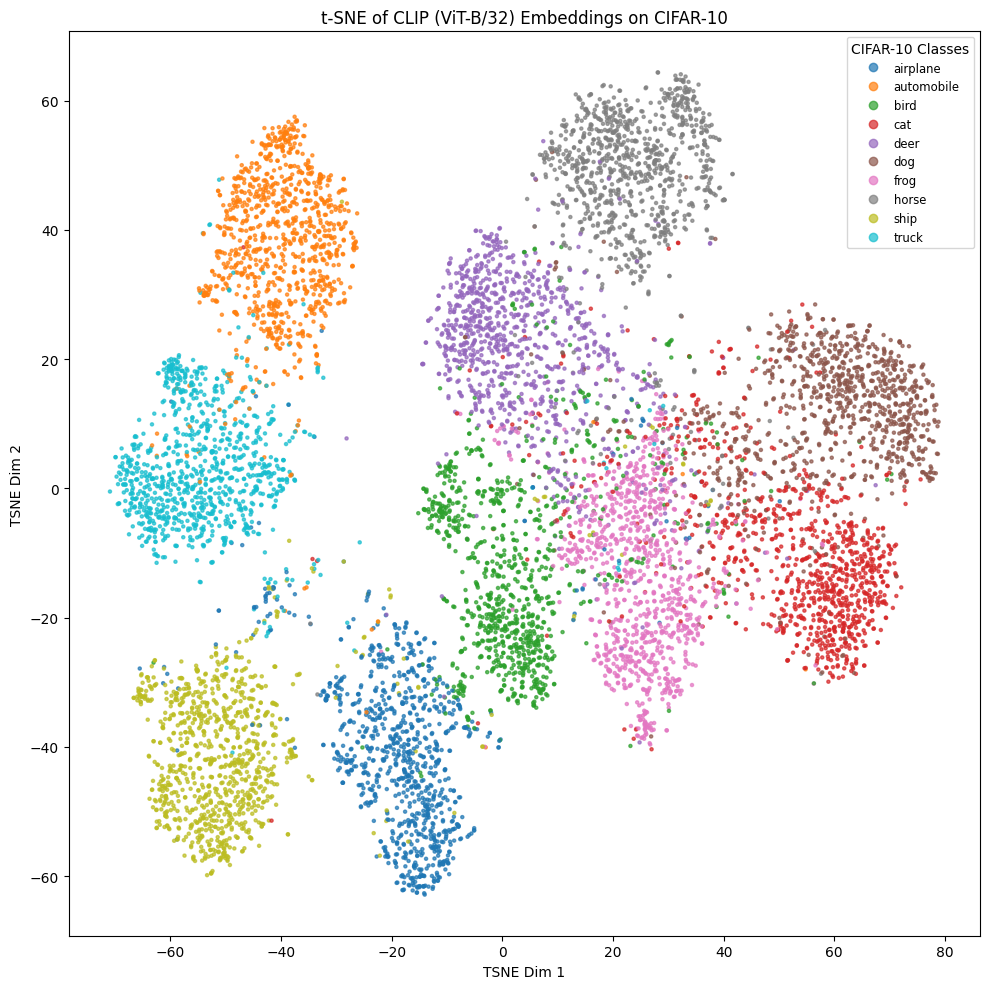

In [5]:
# 5. Reduce to 2D with t-SNE
SEED = 42
print("Reducing to 2D with t-SNE...")
tsne = TSNE(n_components=2, random_state=SEED, init="pca", learning_rate="auto")
embeds_2d = tsne.fit_transform(embeds)
print("t-SNE done. Shape:", embeds_2d.shape)  # (N,2)


# 6. Plot
plt.figure(figsize=(10,10))
scatter = plt.scatter(
    embeds_2d[:,0], embeds_2d[:,1],
    c=labels, cmap="tab10", s=5, alpha=0.7
)
plt.legend(
    handles=scatter.legend_elements()[0],
    labels=dataset.classes,
    title="CIFAR-10 Classes",
    loc="best",
    fontsize="small"
)
plt.title("t-SNE of CLIP (ViT-B/32) Embeddings on CIFAR-10")
plt.xlabel("TSNE Dim 1")
plt.ylabel("TSNE Dim 2")
plt.tight_layout()
plt.show()

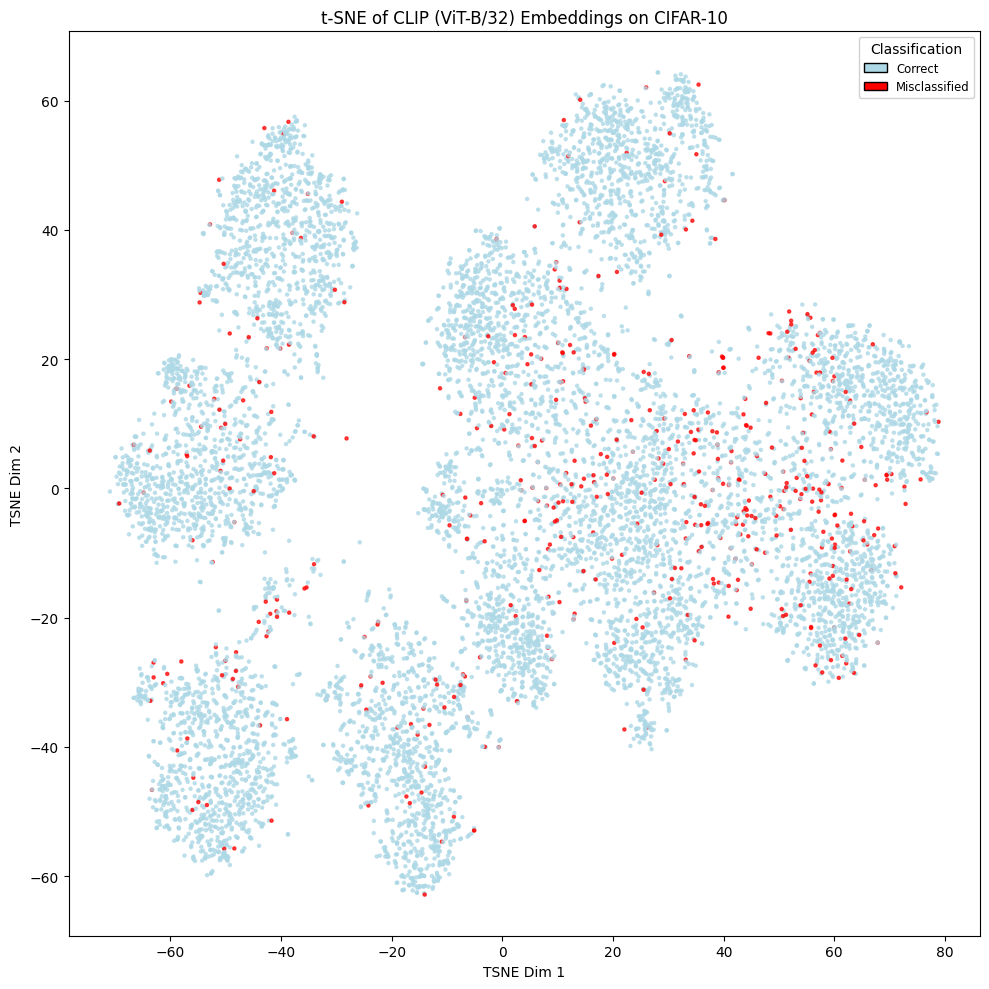

In [ ]:
# 6. Plot
from matplotlib.patches import Patch
plt.figure(figsize=(10,10))

color_map = {0: "lightblue", 1: "red"}
colors    = [color_map[c] for c in train_detector_labels * 1]
scatter = plt.scatter(
    embeds_2d[:,0], embeds_2d[:,1],
    c=colors ,  s=5, alpha=0.7
)
legend_handles = [
    Patch(facecolor="lightblue", edgecolor="k", label="Correct"),
    Patch(facecolor="red",       edgecolor="k", label="Misclassified"),
]

plt.legend(
    handles=legend_handles,
    title="Classification",
    loc="best",
    fontsize="small",
    frameon=True,
    framealpha=0.9
)

plt.title("t-SNE of CLIP (ViT-B/32) Embeddings on CIFAR-10")
plt.xlabel("TSNE Dim 1")
plt.ylabel("TSNE Dim 2")
plt.tight_layout()
plt.show()


In [ ]:
RESULTS_DIR = "../../../synth_results/all_cfiar10/experiment_3"

data = np.load(os.path.join(RESULTS_DIR, "detector_train_predictions.npz"),  allow_pickle=True)
train_embs = data["embs"]
train_detector_preds = data["detector_preds"]
train_detector_labels = data["detector_labels"]
train_clusters = data["clusters"]


### UMAP

Reducing to 2D with UMAP...


/home/lamsade/msammut/error_detection/error-estimation/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP done. Shape: (10000, 2)


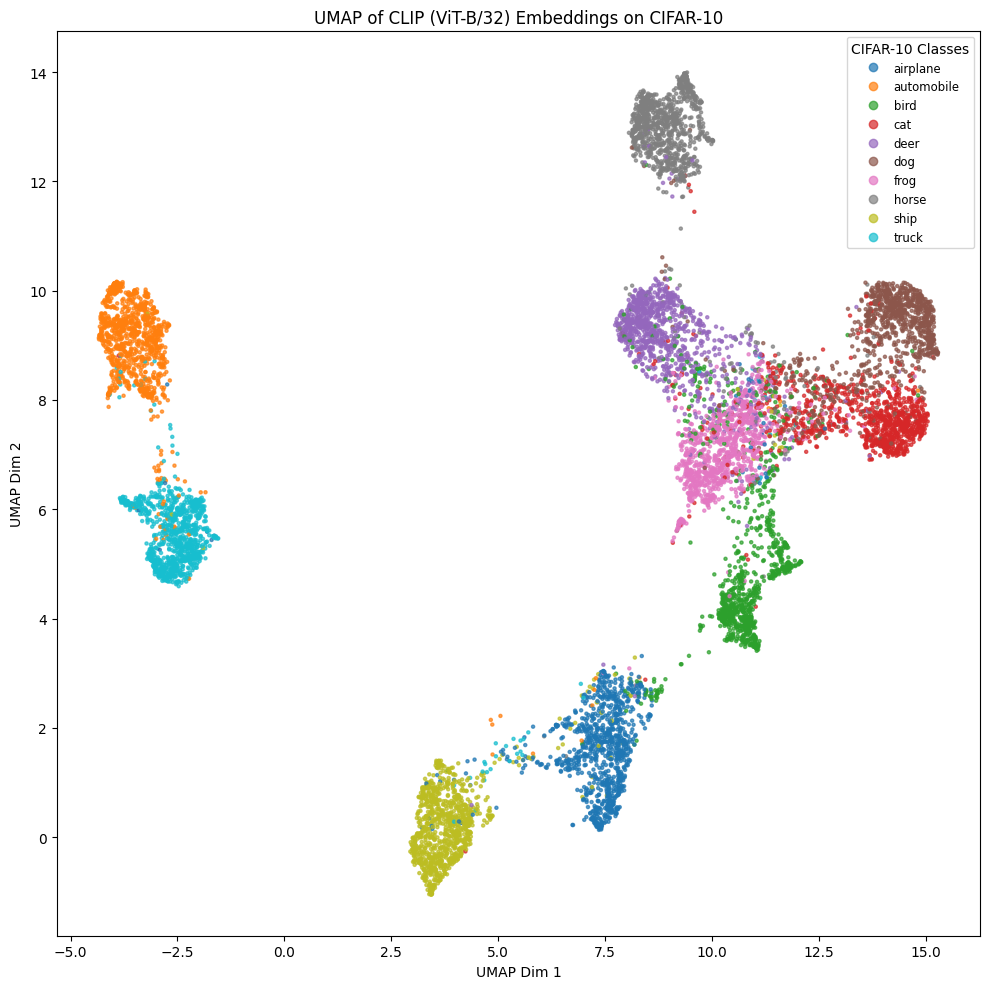

In [26]:
# 5. Reduce to 2D with t-SNE
SEED = 42
print("Reducing to 2D with UMAP...")
reducing_dim = 2
n_neighbors = 4
embeds_2d = umap.UMAP(
    # metric='cosine',
    # n_components=reducing_dim,
    # n_neighbors= n_neighbors
                    ).fit_transform(embeds)
print("UMAP done. Shape:", embeds_2d.shape)  # (N,2)


# 6. Plot
plt.figure(figsize=(10,10))
scatter = plt.scatter(
    embeds_2d[:,0], embeds_2d[:,1],
    c=labels, cmap="tab10", s=5, alpha=0.7
)
plt.legend(
    handles=scatter.legend_elements()[0],
    labels=dataset.classes,
    title="CIFAR-10 Classes",
    loc="best",
    fontsize="small"
)
plt.title("UMAP of CLIP (ViT-B/32) Embeddings on CIFAR-10")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.tight_layout()
plt.show()

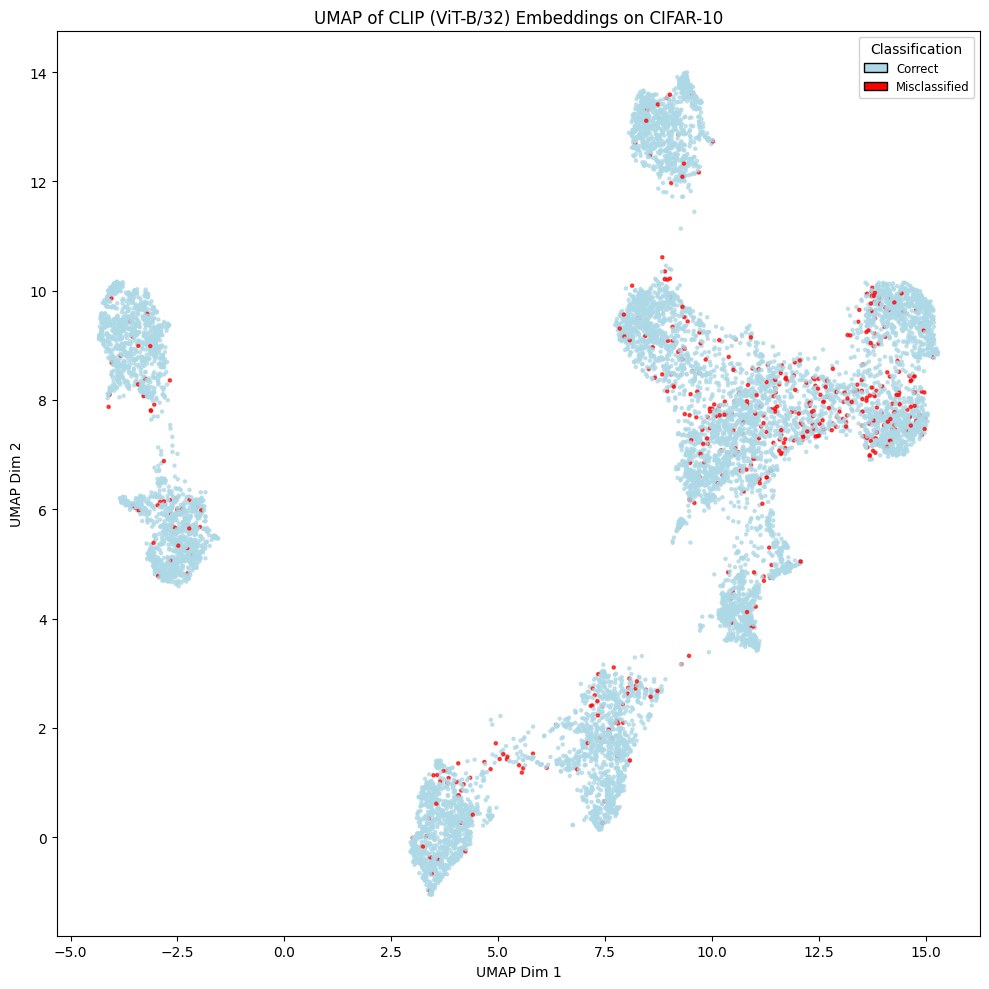

In [27]:
plt.figure(figsize=(10,10))

color_map = {0: "lightblue", 1: "red"}
colors    = [color_map[c] for c in train_detector_labels * 1]
scatter = plt.scatter(
    embeds_2d[:,0], embeds_2d[:,1],
    c=colors ,  s=5, alpha=0.7
)
legend_handles = [
    Patch(facecolor="lightblue", edgecolor="k", label="Correct"),
    Patch(facecolor="red",       edgecolor="k", label="Misclassified"),
]

plt.legend(
    handles=legend_handles,
    title="Classification",
    loc="best",
    fontsize="small",
    frameon=True,
    framealpha=0.9
)

plt.title("UMAP of CLIP (ViT-B/32) Embeddings on CIFAR-10")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.tight_layout()
plt.show()

# Synthetic Data dim 3072

## True Proba Error

In [ ]:
RESULTS_DIR = "../../../synth_results/resnet34/experiment_83"

data = np.load(os.path.join(RESULTS_DIR, "detector_train_predictions.npz"))
train_embs = data["embs"]
train_detector_preds = data["detector_preds"]
train_detector_labels = data["detector_labels"]
train_clusters = data["clusters"]


array([nan, nan], dtype=float32)

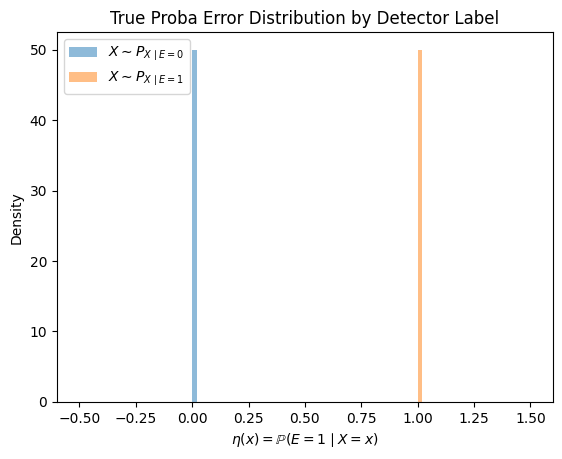

In [16]:
X_0 = train_detector_preds[train_detector_labels == 0]
X_1 = train_detector_preds[train_detector_labels == 1]

# Plot distributions
plt.figure()
plt.hist(X_0, bins=50, density=True, alpha=0.5, label=r"$X \sim P_{X \mid E=0}$")
plt.hist(X_1, bins=50, density=True, alpha=0.5, label=r"$X \sim P_{X \mid E=1}$")
plt.xlabel(r"$\eta(x) = \mathbb{P}( E=1  \mid X =x)$")
plt.ylabel("Density")
plt.title("True Proba Error Distribution by Detector Label")
plt.legend()
plt.show()

*Clustering True Proba Error*

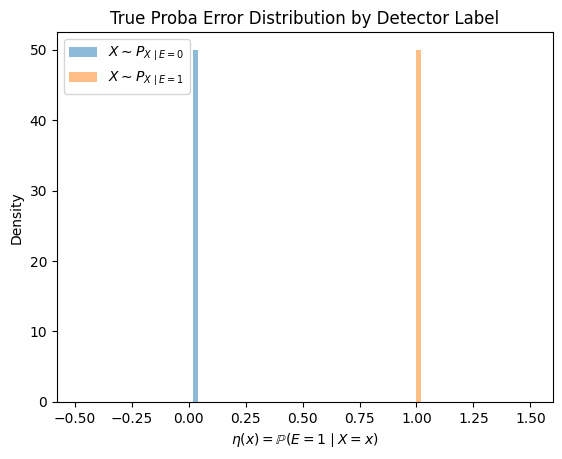

In [5]:
RESULTS_DIR = "../../../synth_results/cifar10/experiment_84"

data = np.load(os.path.join(RESULTS_DIR, "detector_train_predictions.npz"))
train_embs = data["embs"]
train_detector_preds = data["detector_preds"]
train_detector_labels = data["detector_labels"]
train_clusters = data["clusters"]

X_0 = train_detector_preds[train_detector_labels == 0]
X_1 = train_detector_preds[train_detector_labels == 1]

# Plot distributions
plt.figure()
plt.hist(X_0, bins=50, density=True, alpha=0.5, label=r"$X \sim P_{X \mid E=0}$")
plt.hist(X_1, bins=50, density=True, alpha=0.5, label=r"$X \sim P_{X \mid E=1}$")
plt.xlabel(r"$\eta(x) = \mathbb{P}( E=1  \mid X =x)$")
plt.ylabel("Density")
plt.title("True Proba Error Distribution by Detector Label")
plt.legend()
plt.show()


## Gini

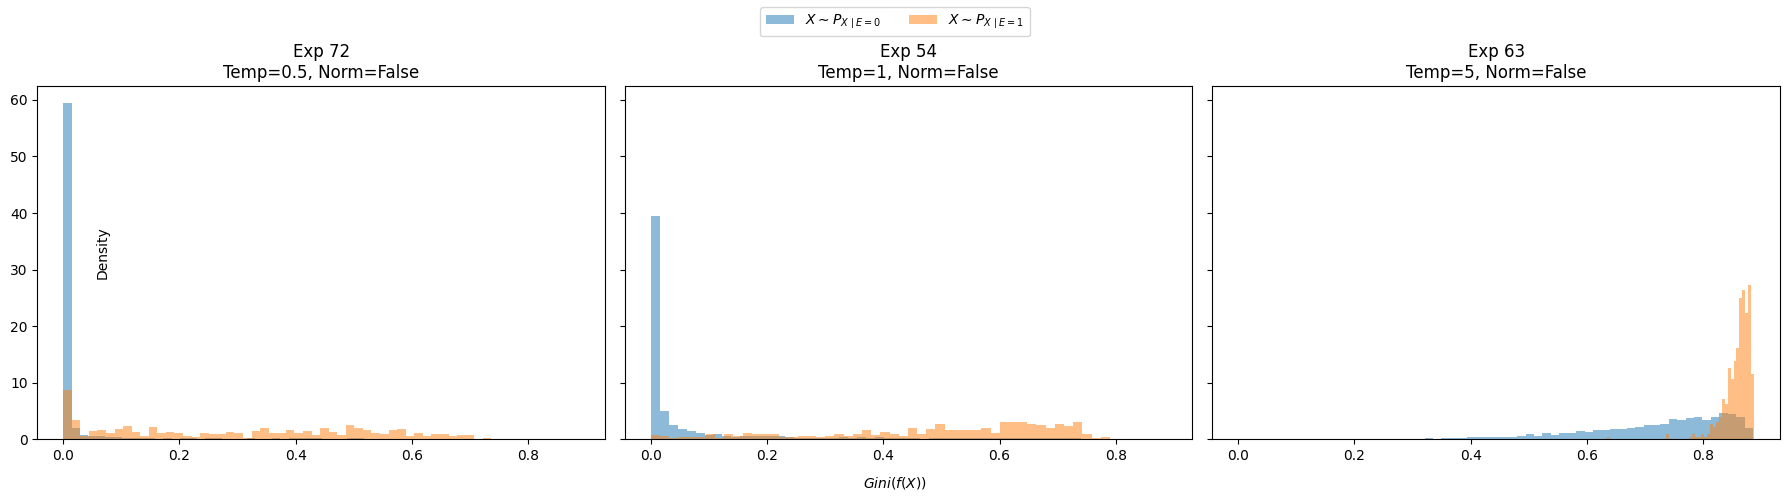

In [26]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Experiment IDs
experiment_ids = [72, 54, 63]

# Create subplots with shared axes
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

for ax, exp_id in zip(axes, experiment_ids):
    # Construct paths
    results_dir = f"../../../synth_results/resnet3072/experiment_{exp_id}"
    config_path = os.path.join(results_dir, "config.json")
    data_path = os.path.join(results_dir, "detector_train_predictions.npz")
    
    # Check for existence
    if not os.path.exists(config_path) or not os.path.exists(data_path):
        ax.set_title(f"Exp {exp_id}\nFiles not found")
        ax.axis('off')
        continue
    
    # Load config
    with open(config_path, "r") as f:
        config = json.load(f)
    
    # Load data
    data = np.load(data_path)
    preds = data["detector_preds"]
    labels = data["detector_labels"]
    
    # Split predictions by label
    X0 = preds[labels == 0]
    X1 = preds[labels == 1]
    
    # Plot histograms
    ax.hist(X0, bins=50, density=True, alpha=0.5, label=r"$X \sim P_{X \mid E=0}$")
    ax.hist(X1, bins=50, density=True, alpha=0.5, label=r"$X \sim P_{X \mid E=1}$")
    
    # Title
    temp = config.get("gini", {}).get("temperature", "N/A")
    norm = config.get("gini", {}).get("normalize_gini", "N/A")
    ax.set_title(f"Exp {exp_id}\nTemp={temp}, Norm={norm}")

# Common labels
fig.text(0.5, 0.04, r"$Gini(f(X))$", ha='center', va='center')
fig.text(0.06, 0.5, "Density", ha='center', va='center', rotation='vertical')

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


## N_cluster = 100

In [12]:
RESULTS_DIR = "../../../synth_results/clustering_probits/experiment_1"

data = np.load(os.path.join(RESULTS_DIR, "detector_train_predictions.npz"))
train_embs = data["embs"]
train_detector_preds = data["detector_preds"]
train_detector_labels = data["detector_labels"]
train_clusters = data["clusters"]


In [15]:
reducing_dim = 2
n_neighbors = 15
reducer = umap.UMAP(
    # n_components=reducing_dim,
    # n_neighbors= n_neighbors
                    ).fit(train_embs)



/home/lamsade/msammut/error_detection/error-estimation/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: >

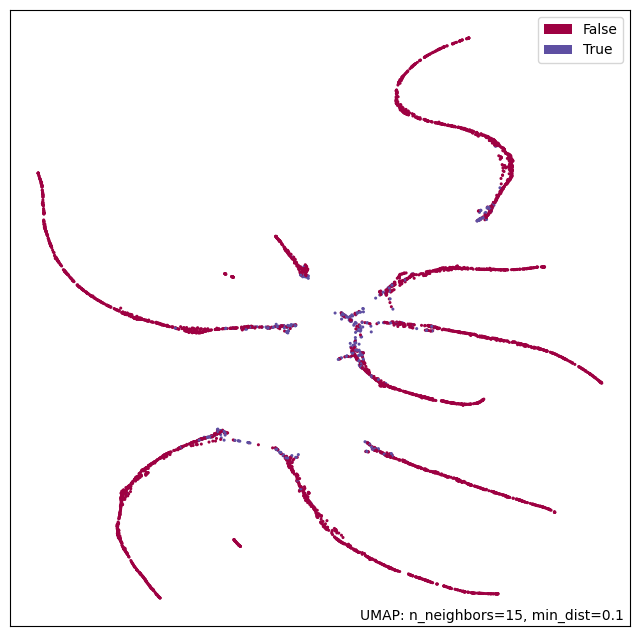

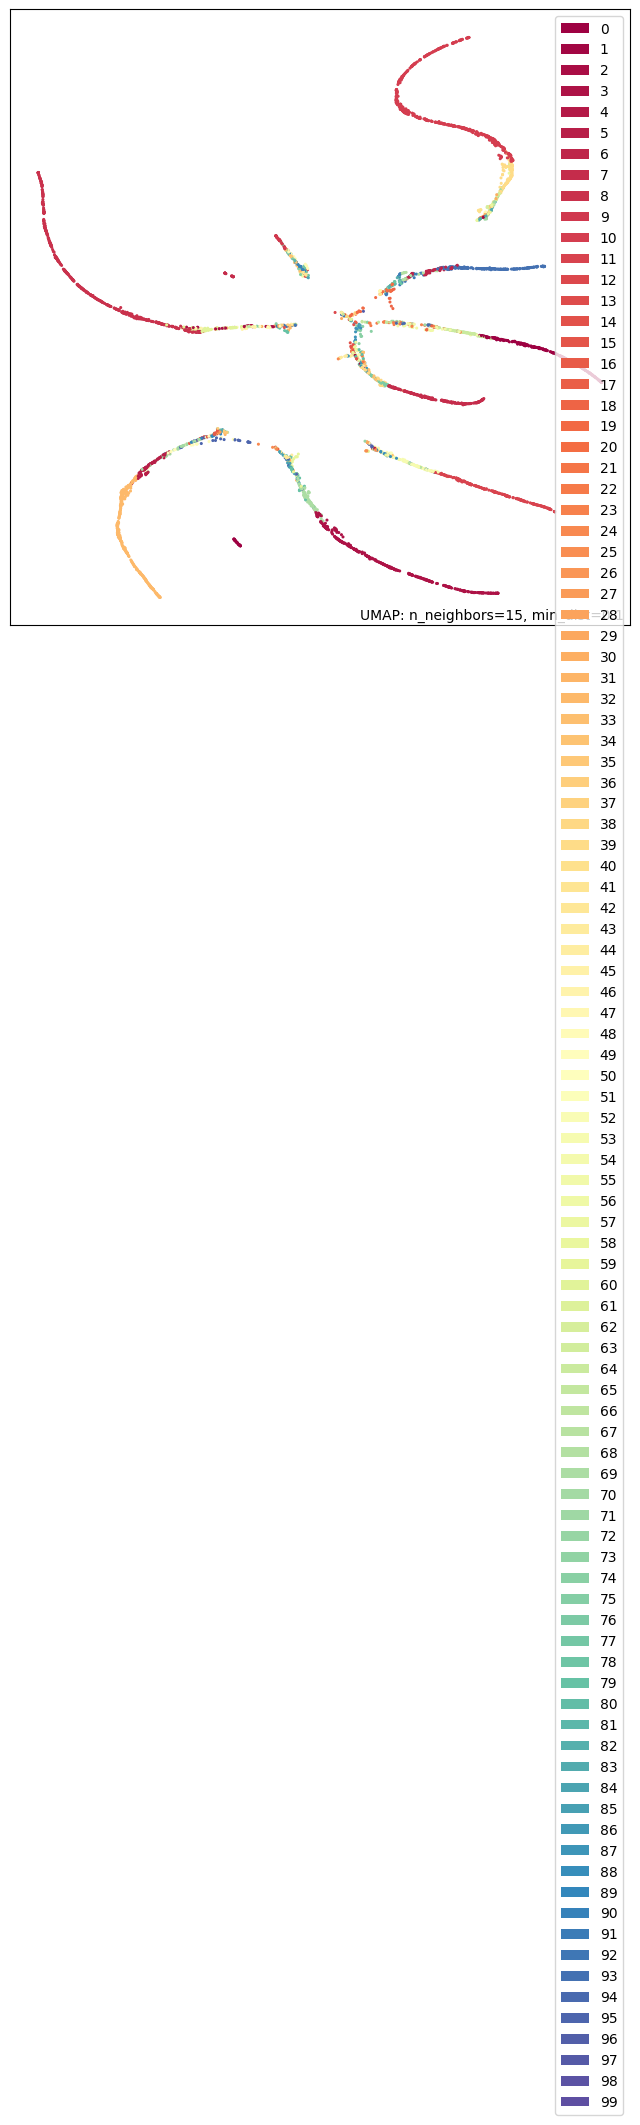

In [16]:
umap.plot.points(reducer, labels = train_detector_labels)
umap.plot.points(reducer, labels = train_clusters)

## n_cluster = 10

In [15]:
RESULTS_DIR = "../../../synth_results/clustering_probits/experiment_2"

data = np.load(os.path.join(RESULTS_DIR, "detector_train_predictions.npz"))
train_embs = data["embs"]
train_detector_preds = data["detector_preds"]
train_detector_labels = data["detector_labels"]
train_clusters = data["clusters"]


/home/lamsade/msammut/error_detection/error-estimation/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lamsade/msammut/error_detection/error-estimation/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


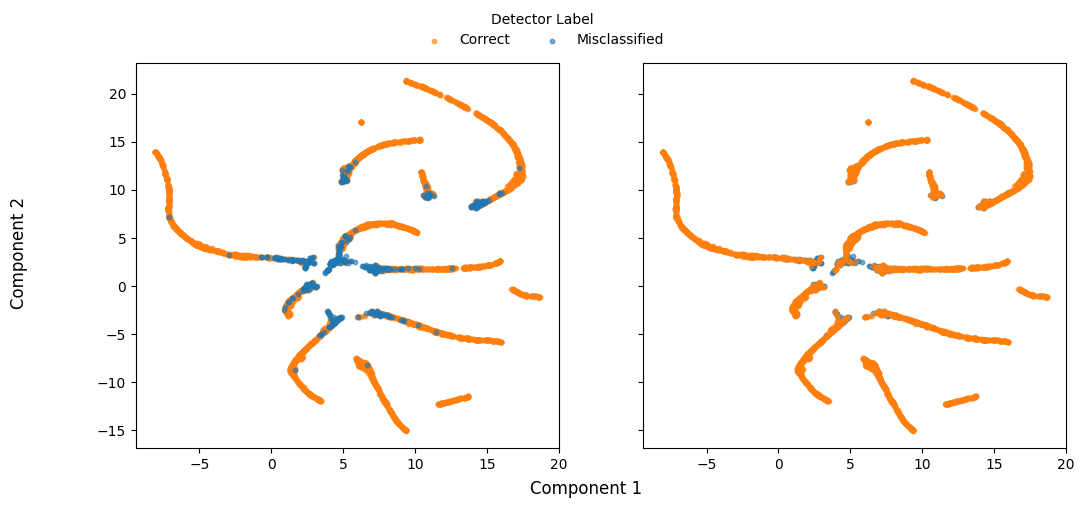

In [16]:
reducing_dim = 2
n_neighbors = 4
reducer = umap.UMAP(
    metric='euclidean',
    # n_components=reducing_dim,
    # n_neighbors= n_neighbors
                    ).fit(train_embs)


X = reducer.transform(train_embs)
colour_map = {0: "tab:orange", 1: "tab:blue"}
label_names = {0: "Correct",  1: "Misclassified"}
orders = [
    ([0, 1], "Draw order: 0 → 1"),
    ([1, 0], "Draw order: 1 → 0")
]

# 1×2 grid, shared axes
fig, axes = plt.subplots(
    1, 2,
    figsize=(12, 5),
    sharex=True,
    sharey=True
)

# Plot into each subplot
for ax, (order, title) in zip(axes, orders):
    for label in order:
        mask = (train_detector_labels == label)
        ax.scatter(
            X[mask, 0], X[mask, 1],
            c=colour_map[label],
            s=10,
            alpha=0.6,
            label=label_names[label]
        )
    # ax.set_title()

# Extract one set of handles & labels, then make a single legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title="Detector Label",
    loc="upper center",
    ncol=2,
    frameon=False
)

# Common axis labels
fig.supxlabel("Component 1")
fig.supylabel("Component 2")

# Adjust layout so legend and labels fit
# plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


/home/lamsade/msammut/error_detection/error-estimation/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lamsade/msammut/error_detection/error-estimation/myenv/lib/python3.11/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/lamsade/msammut/error_detection/error-estimation/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


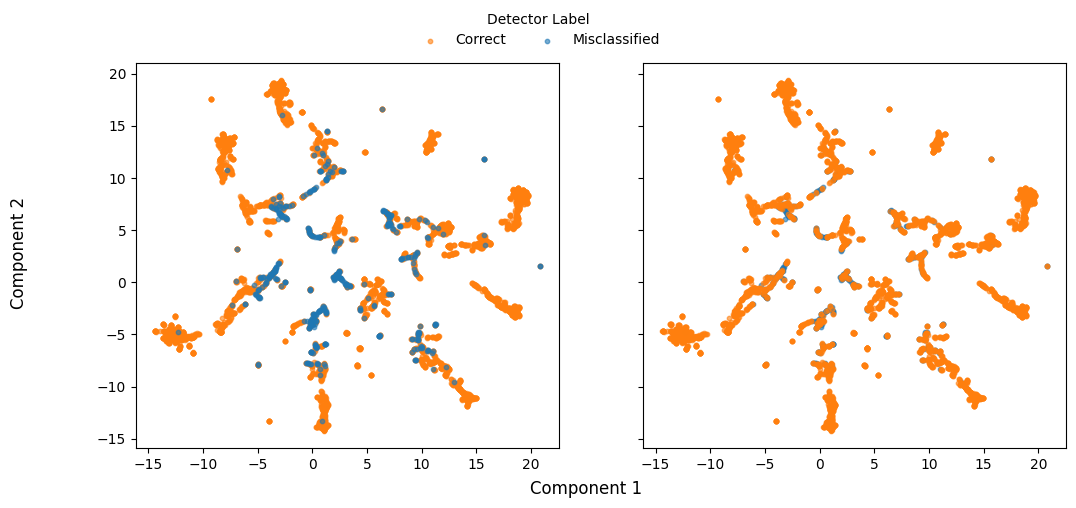

In [21]:
reducing_dim = 2
n_neighbors = 4
reducer = umap.UMAP(
    metric='cosine',
    # n_components=reducing_dim,
    n_neighbors= n_neighbors
                    ).fit(train_embs)


X = reducer.transform(train_embs)
colour_map = {0: "tab:orange", 1: "tab:blue"}
label_names = {0: "Correct",  1: "Misclassified"}
orders = [
    ([0, 1], "Draw order: 0 → 1"),
    ([1, 0], "Draw order: 1 → 0")
]

# 1×2 grid, shared axes
fig, axes = plt.subplots(
    1, 2,
    figsize=(12, 5),
    sharex=True,
    sharey=True
)

# Plot into each subplot
for ax, (order, title) in zip(axes, orders):
    for label in order:
        mask = (train_detector_labels == label)
        ax.scatter(
            X[mask, 0], X[mask, 1],
            c=colour_map[label],
            s=10,
            alpha=0.6,
            label=label_names[label]
        )
    # ax.set_title()

# Extract one set of handles & labels, then make a single legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title="Detector Label",
    loc="upper center",
    ncol=2,
    frameon=False
)

# Common axis labels
fig.supxlabel("Component 1")
fig.supylabel("Component 2")

# Adjust layout so legend and labels fit
# plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


/home/lamsade/msammut/error_detection/error-estimation/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: >

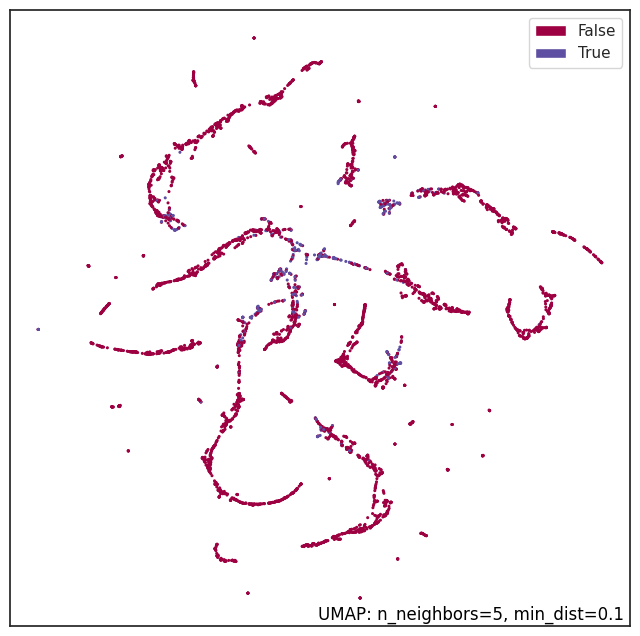

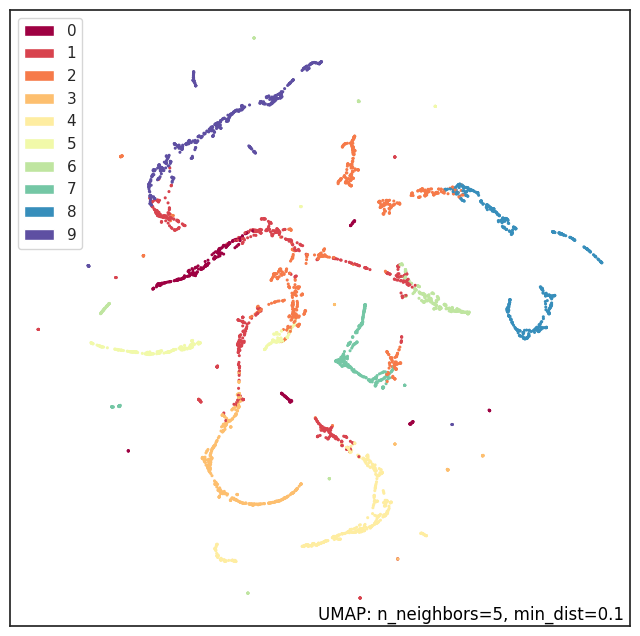

In [36]:
reducing_dim = 2
n_neighbors = 5
reducer = umap.UMAP(
    n_components=reducing_dim,
    n_neighbors= n_neighbors
                    ).fit(train_embs)
umap.plot.points(reducer, labels = train_detector_labels, cmap='viridis')
umap.plot.points(reducer, labels = train_clusters)


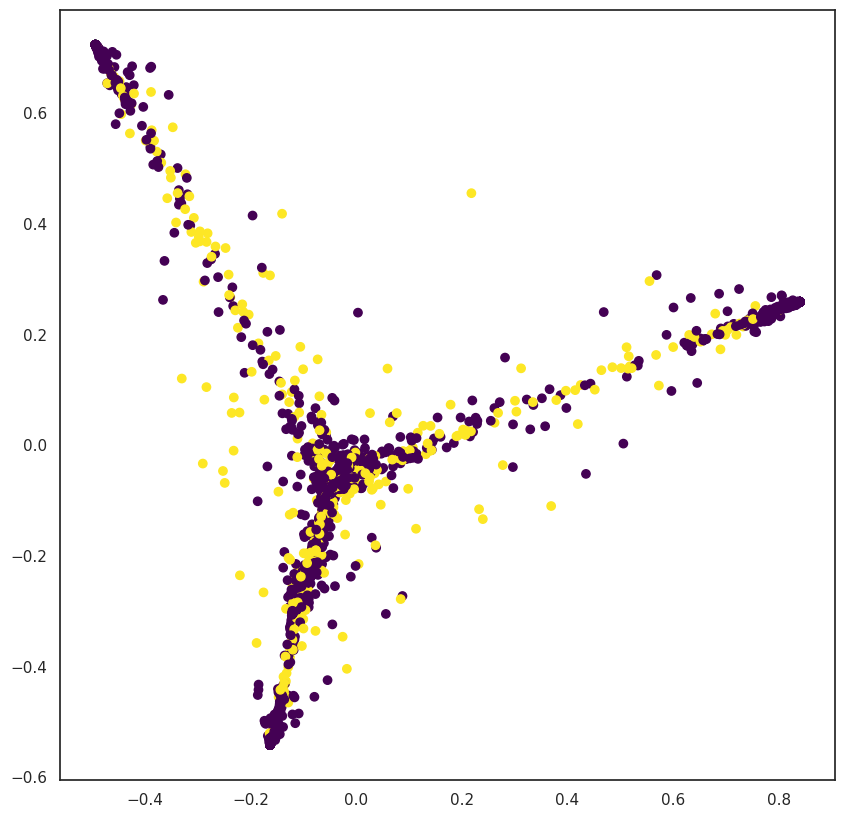

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(train_embs)

plt.scatter(data_reduced[:,0], data_reduced[:,1], c=train_detector_labels, cmap='viridis')

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
%matplotlib inline

In [17]:
sns.set(palette="pastel", rc={'figure.figsize':(10,10)})
np.random.seed(42)

In [34]:
def draw_umap(data, labels, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data)
    fig = plt.figure(figsize=(5, 5))
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=labels)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=labels,  cmap='viridis')
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=labels, cmap='viridis')
    plt.title(title, fontsize=18)
    plt.show()

In [1]:
# for metric in ["euclidean", "manhattan", "chebyshev", "minkowski", "canberra", "braycurtis", "mahalanobis", "wminkowski", "seuclidean", "cosine", "correlation",
#                "haversine", "hamming", "jaccard", "dice", "russelrao", "kulsinski", "ll_dirichlet", "hellinger", "rogerstanimoto", "sokalmichener", "sokalsneath", "yule"]:

#     for n in (2, 5, 10, 20, 50, 100, 200):
#         print("n_neighbors = {}, metric = {}".format(n, metric))
#         draw_umap(data=train_embs, labels=train_detector_labels, n_neighbors=n, n_components=2, metric="cosine", title='n_neighbors = {}'.format(n))

/home/lamsade/msammut/error_detection/error-estimation/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


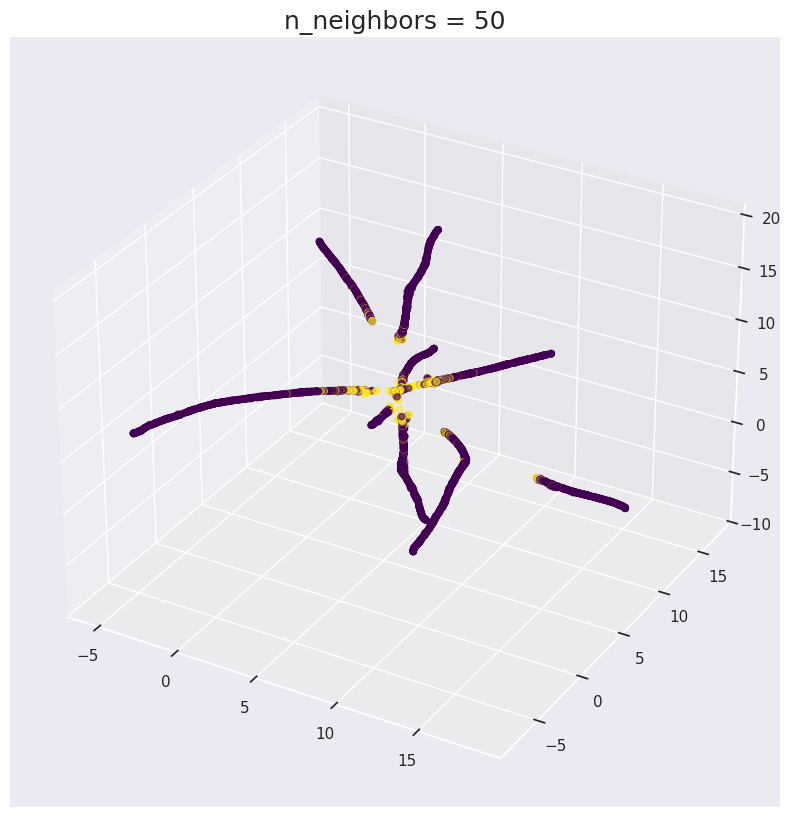

In [25]:
for n in [50]:
    draw_umap(data=train_embs, labels=train_detector_labels, n_neighbors=n, n_components=3, title='n_neighbors = {}'.format(n))

In [2]:
# for n in (2, 5, 10, 20, 50, 100, 200):
#     draw_umap(data=train_embs, labels=train_detector_labels, n_neighbors=n, n_components=3, title='n_neighbors = {}'.format(n))

# Testing Bregman Clustering

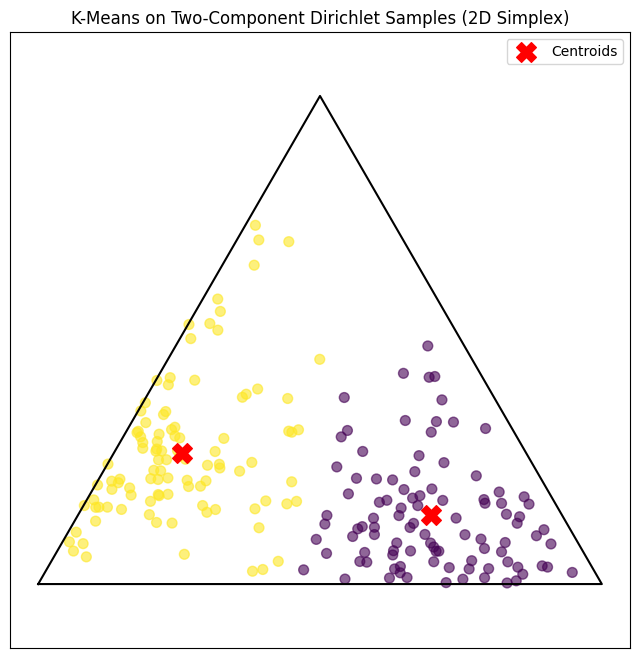

Inertia 9.885747841987637


In [3]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. Setup RNG
seed = 42
rng = np.random.default_rng(seed)

# 2. Sample from two Dirichlet distributions
n_per = 100
alpha1 = [2, 5, 1]    # first mixture component
alpha2 = [5, 1, 2]    # second mixture component
X1 = rng.dirichlet(alpha1, size=n_per)
X2 = rng.dirichlet(alpha2, size=n_per)
X  = np.vstack([X1, X2])             # shape (200, 3)

# 3. Perform K-Means in 3D
kmeans = KMeans(n_clusters=n_clusters,
                    init=initializer,
                    n_init=init_iters,
                    max_iter=n_iters,
                 random_state=seed)
labels = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_

# 4. Barycentric → Cartesian for plotting
v1 = np.array([0.0, 0.0])
v2 = np.array([1.0, 0.0])
v3 = np.array([0.5, np.sqrt(3)/2])

def to_cartesian(simplex_pts):
    # simplex_pts: (N,3) rows sum to 1
    return (
        simplex_pts[:, [0]] * v1 +
        simplex_pts[:, [1]] * v2 +
        simplex_pts[:, [2]] * v3
    )

X2d = to_cartesian(X)
centers2d = to_cartesian(centers)

# 5. Plot
plt.figure(figsize=(8, 8))

# Draw simplex boundary
triangle = np.vstack([v1, v2, v3, v1])
plt.plot(triangle[:, 0], triangle[:, 1], 'k-', lw=1.5)

# Scatter samples
plt.scatter(
    X2d[:, 0], X2d[:, 1],
    c=labels, cmap='viridis',
    s=50, alpha=0.6
)

# Plot centroids
plt.scatter(
    centers2d[:, 0], centers2d[:, 1],
    c='red', marker='X',
    s=200, label='Centroids'
)

plt.title('K-Means on Two-Component Dirichlet Samples (2D Simplex)')
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.legend(loc='upper right')
plt.show()

print("Inertia", kmeans.inertia_)


In [3]:
import os
import sys
from sklearn.cluster import KMeans
ROOT_PATH = "/home/lamsade/msammut/error_detection/error-estimation/synthetic_code"
sys.path.append(ROOT_PATH)

from utils.clustering.models import BregmanHard

n_clusters = 3
seed = 17
initializer = "random"  # or "kmeans", "kmedoids", etc.
max_iter = 10  # number of iterations for the clustering algorithm
n_init = 1  # number of iterations for the initializer

rng = np.random.default_rng(seed)

# 2. Sample from two Dirichlet distributions
n_per = 100
alpha1 = [2, 5, 1]    # first mixture component
alpha2 = [5, 1, 2]    # second mixture component
X1 = rng.dirichlet(alpha1, size=n_per)
X2 = rng.dirichlet(alpha2, size=n_per)
X  = np.vstack([X1, X2])    

kmeans = KMeans(n_clusters=n_clusters,
                    init=initializer,
                    n_init=n_init,
                    max_iter=max_iter,
                 random_state=seed,
                 verbose=5)
labels = kmeans.fit_predict(X)
print(np.unique(labels, return_counts=True))
print("KMeans Inertia:", kmeans.inertia_)
bregmanhard = BregmanHard(
    n_clusters=n_clusters,
    max_iter=max_iter,
    initializer=initializer,
    n_init=n_init,
    random_state=seed
)
bregmanhard.fit(X)
predict_bregamn = bregmanhard.predict(X)
np.unique(predict_bregamn, return_counts=True)



Initialization complete
Iteration 0, inertia 16.31490224201874.
Iteration 1, inertia 8.92426261817473.
Iteration 2, inertia 8.26286823338725.
Iteration 3, inertia 7.678098097521946.
Iteration 4, inertia 7.56742188190503.
Iteration 5, inertia 7.5269825972880655.
Iteration 6, inertia 7.504587336618377.
Iteration 7, inertia 7.489030049404449.
Iteration 8, inertia 7.475574384964744.
Converged at iteration 8: strict convergence.
(array([0, 1, 2], dtype=int32), array([48, 99, 53]))
KMeans Inertia: 7.4755743849647445
init
Inertia 36.84147562483397
Inertia 33.62303123235074
Inertia 33.30257423714788
Inertia 32.977102083563494
Inertia 32.8237397291098
Inertia 32.74957208912389
Inertia 32.68178970910603
Inertia 32.66907876318594
Inertia 32.6498689749431
Inertia 32.62715505451115


AttributeError: 'BregmanHard' object has no attribute 'cluster_centers'